In [56]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.utils import read_from_pickle
import jax.numpy as jnp
from ff_energy.ffe.plot import plot_energy_MSE, plot_ff_fit
from ff_energy.ffe.structure import atom_key_pairs
from ff_energy.ffe.potential import LJ, akp_indx
from ff_energy.ffe.ff import FF
from ff_energy.ffe.ff_fit import LJ_bound, load_ff, fit_func, fit_repeat
from ff_energy.ffe.data import pairs_data
from ff_energy.ffe.utils import pickle_output, read_from_pickle, str2int
from ff_energy.ffe.utils import pickle_output, PKL_PATH, read_from_pickle, str2int
from ff_energy.ffe.data import pairs_data, Data

In [4]:
p = PKL_PATH / "water_cluster/pbe0dz/pbe.pc"
data_tip3 = Data(p)

loading pickles from  /home/boittier/Documents/phd/ff_energy/pickles/water_cluster/pbe0dz/pbe.pc


In [5]:
sig_bound = (0.001, 2.5)
ep_bound = (0.001, 2.5)
chg_bound = (100,2000)

CHGPEN_bound = [(chg_bound),(chg_bound),(chg_bound),(chg_bound),(0,2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), 
            (1, 8), (6, 20))

In [6]:
#  example
# ffpkl = "ECOL_pbe0dz_FOE.ff.pkl"
ffpkl = "kmdcm_pbe0dz_clusters.ff.pkl"

In [7]:
_c = next(read_from_pickle(f"ff/{ffpkl}"))
_c

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


FF: LJ water_cluster ELEC harmonic intE (jax_coloumb: True)

In [8]:
# _c.data["ELEC"] = data_tip3.data["ELEC"]

In [9]:
_c.intE = "ECOL"
_c.set_targets()
_c

FF: LJ water_cluster ELEC harmonic ECOL (jax_coloumb: True)

In [10]:
fit_repeat(_c, 
           1, 
           f"{ffpkl}_chgpen",
           bounds = CHGPEN_bound,
           loss="chgpen",
           # quiet='true'
          )

Optimizing LJ parameters...
function: get_loss_chgpen
bounds: [(100, 2000), (100, 2000), (100, 2000), (100, 2000), (0, 2000)]
maxfev: 10000
initial guess: [1337.449119371105, 1349.3846965526016, 1403.8208935994405, 535.5216256398804, 1538.1775301527518]


/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


final_loss_fn:  134.36691284179688
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 134.36691284179688
             x: [ 1.496e+03  1.438e+03  1.528e+03  5.831e+02  2.640e+02]
           nit: 132
          nfev: 323
 final_simplex: (array([[ 1.496e+03,  1.438e+03, ...,  5.831e+02,
                         2.640e+02],
                       [ 1.496e+03,  1.438e+03, ...,  5.831e+02,
                         2.640e+02],
                       ...,
                       [ 1.496e+03,  1.438e+03, ...,  5.831e+02,
                         2.640e+02],
                       [ 1.496e+03,  1.438e+03, ...,  5.831e+02,
                         2.640e+02]]), array([ 1.344e+02,  1.344e+02,  1.344e+02,  1.344e+02,
                        1.344e+02,  1.344e+02]))


In [11]:
resx = _c.opt_parm 
loss = _c.get_loss_chgpen(resx)
loss
resx

array([1496.14632491, 1437.97792145, 1528.31340887,  583.1027106 ,
        263.96652248])

In [12]:
np.sqrt(loss)

11.591674

In [13]:
# _c.eval_jax_chgpen(resx ) 

5.8172749640363945e-185


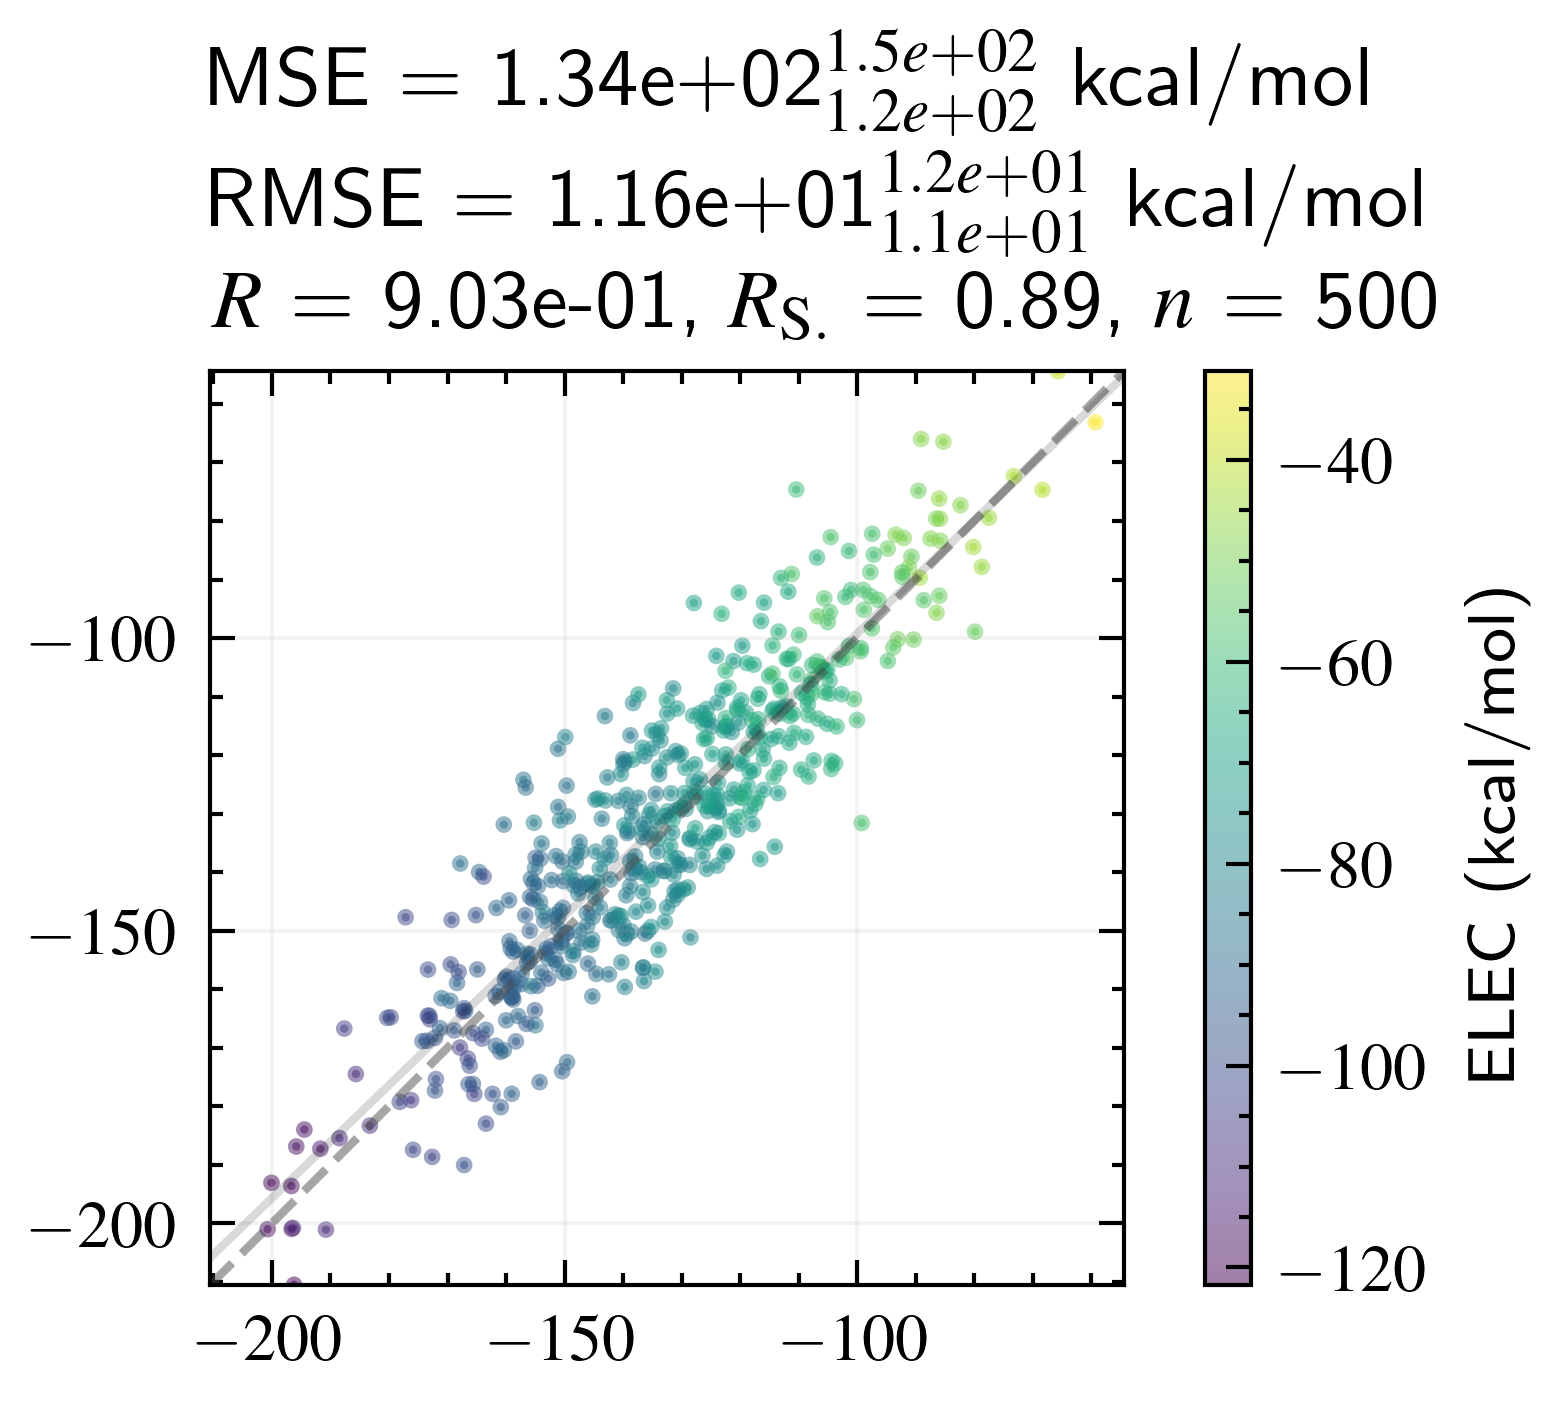

In [14]:
# _c.eval_jax_chgpen(resx ) 
_c.data["fit_ECOL"] = _c.eval_jax_chgpen(resx ) + _c.data.ELEC

plot_energy_MSE(_c.data, "ECOL", "fit_ECOL",  elec = "ELEC")

plt.savefig("kmdcm_fit_ecol.pdf")

0.0


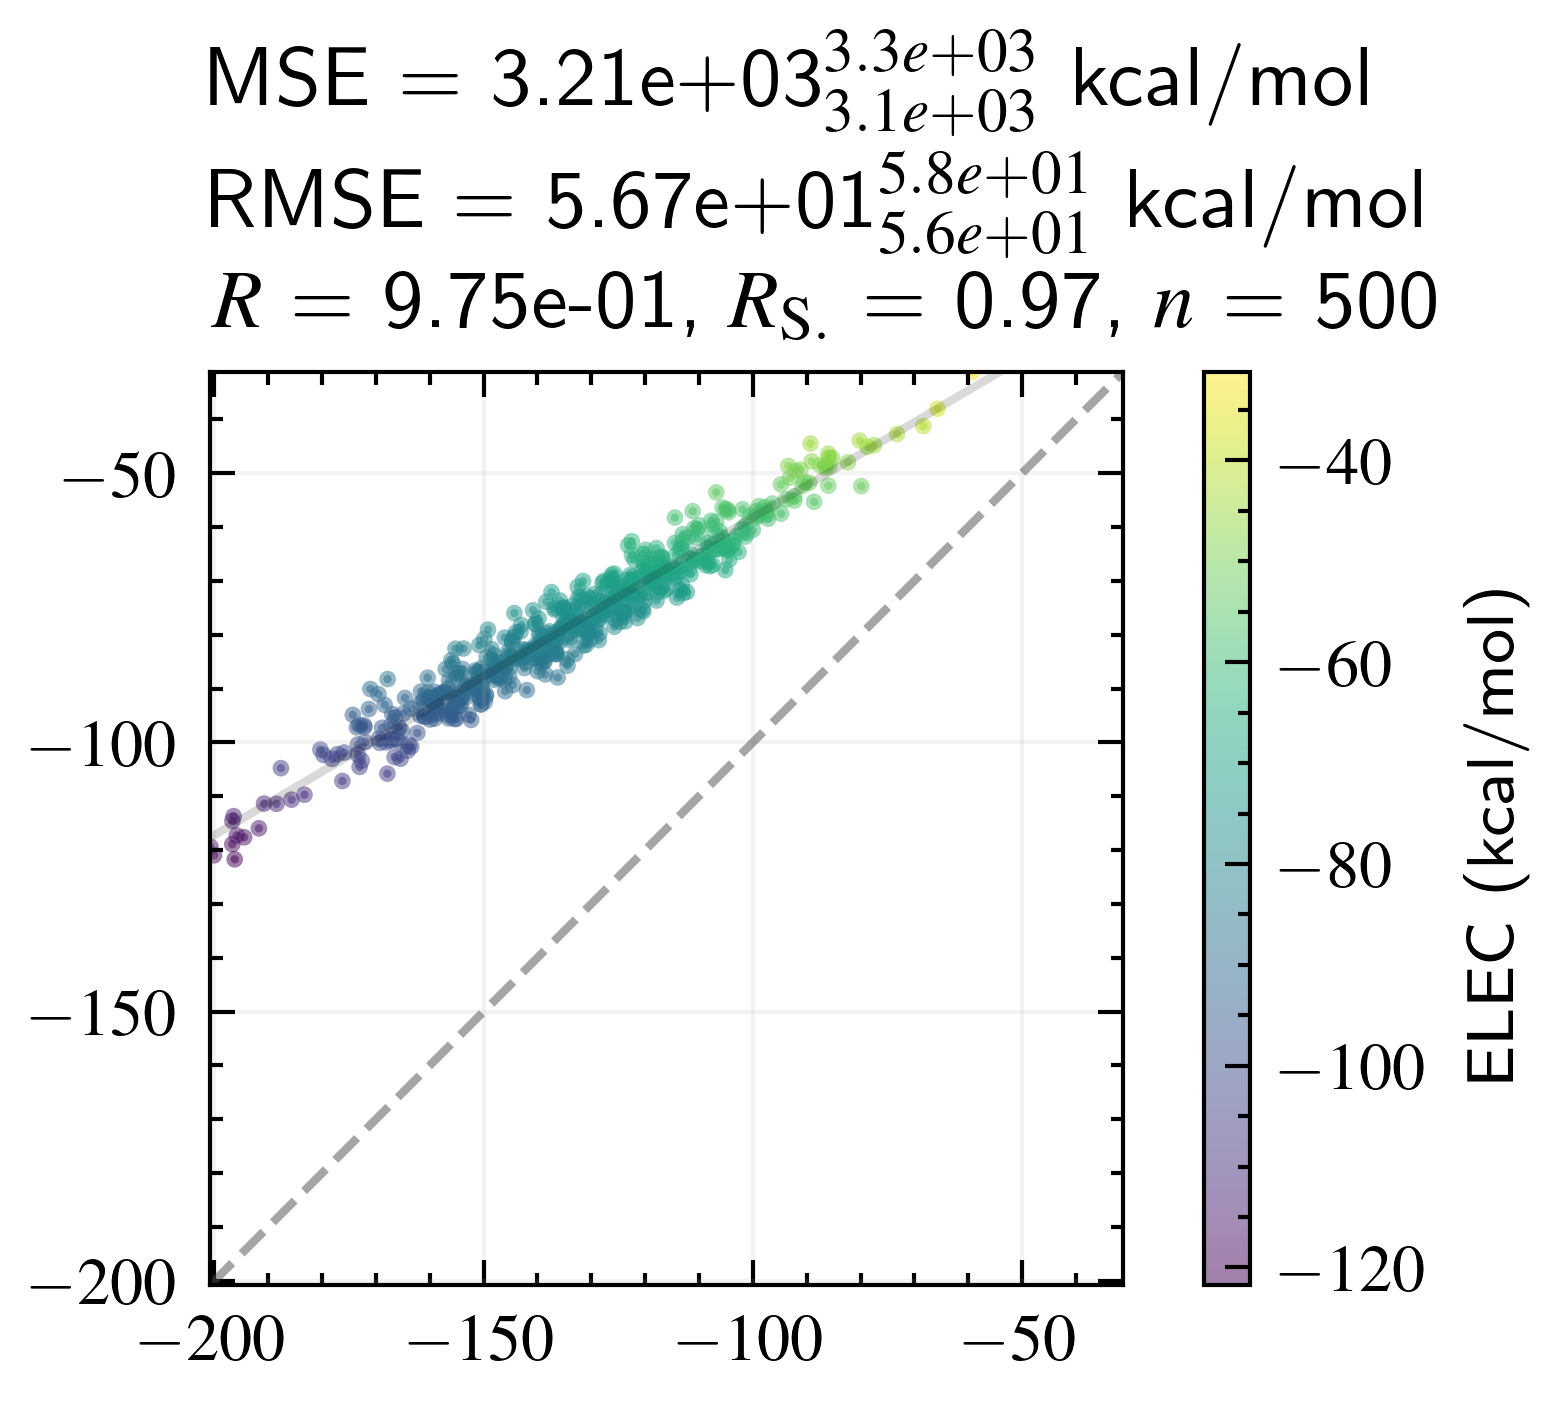

In [15]:
plot_energy_MSE(_c.data, "ECOL", "ELEC",  elec = "ELEC")
plt.savefig("kmdcm_ecol.pdf")

In [16]:
_c.data["fit_ECOL"].mean()

-131.85739

In [17]:
pickle_output(_c, "ff/fit_ECOL_kmdcm_intE")

#  LJ fit


In [18]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_kmdcm_intE.pkl"))

In [19]:
LJFF.elec = "ELEC"
LJFF.intE = "intE"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

19.06506


FF: LJ water_cluster ELEC harmonic intE (jax_coloumb: True)

In [20]:
fit_repeat(LJFF, 
           15, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [21]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

fun  nit  nfev  status  success  \
7    16.195114  385   685       0     True   
2    20.635584   91   182       0     True   
9    21.945210  680  1187       0     True   
15   30.692957  304   549       0     True   
4   103.624413  126   248       0     True   
0   134.366913  132   323       0     True   
3   418.809387   46   154       0     True   
5   418.809387   40   137       0     True   
6   418.809387   37   126       0     True   
8   418.809387   44   152       0     True   
10  418.809387   45   162       0     True   
11  418.809387   34   128       0     True   
12  418.809387   37   145       0     True   
13  418.809387   56   168       0     True   
14  418.809387   33   124       0     True   
1   548.908386  142   267       0     True   

                                  message  \
7   Optimization terminated successfully.   
2   Optimization terminated successfully.   
9   Optimization terminated successfully.   
15  Optimization terminated successfully.   
4   Optimization terminated successfully.   
0   Optimization terminated successfully.   
3   Optimization terminated successfully.   
5   Optimization terminated successfully.   
6   Optimization terminated successfully.   
8   Optimization terminated successfully.   
10  Optimization terminated successfully.   
11  Optimization terminated successfully.   
12  Optimization terminated successfully.   
13  Optimization terminated successfully.   
14  Optimization terminated successfully.   
1   Optimization terminated successfully.   

                                                    x  \
7   [0.001, 1.8075449678683502, 0.2342334456853799...   
2               [0.001, 2.37682358759135, 2.5, 0.001]   
9   [1.5683227388679306, 1.7245826768708499, 0.001...   
15  [1.6992994210533365, 0.7577646404670293, 0.001...   
4            [1.863996680384731, 0.001, 0.001, 0.001]   
0   [1496.1463249145506, 1437.977921449105, 1528.3...   
3   [0.001, 0.029737538352729187, 0.83994214148901...   
5   [0.001, 0.0630635932327347, 2.485934411934334,...   
6   [0.001, 0.06572866782652684, 0.389662713871651...   
8   [0.001, 0.04996762805236199, 1.726869319806821...   
10  [0.001, 0.04073966809118362, 0.272732165592594...   
11  [0.001, 0.012380531656992266, 2.5, 0.243572013...   
12  [0.03221148273684271, 0.02298987916278588, 1.4...   
13  [0.03222011391269797, 0.001, 1.756476486302902...   
14  [0.001, 0.0229420313980526, 0.3778303389597520...   
1   [0.0010004414165709396, 1.6445756155952407, 0....   

                                        final_simplex  
7   ([[0.001, 1.8075449678683502, 0.23423344568537...  
2   ([[0.001, 2.37682358759135, 2.5, 0.001], [0.00...  
9   ([[1.5683227388679306, 1.7245826768708499, 0.0...  
15  ([[1.6992994210533365, 0.7577646404670293, 0.0...  
4   ([[1.863996680384731, 0.001, 0.001, 0.001], [1...  
0   ([[1496.1463249145506, 1437.977921449105, 1528...  
3   ([[0.001, 0.029737538352729187, 0.839942141489...  
5   ([[0.001, 0.0630635932327347, 2.48593441193433...  
6   ([[0.001, 0.06572866782652684, 0.3896627138716...  
8   ([[0.001, 0.04996762805236199, 1.7268693198068...  
10  ([[0.001, 0.04073966809118362, 0.2727321655925...  
11  ([[0.001, 0.012380531656992266, 2.5, 0.2435720...  
12  ([[0.03221148273684271, 0.02298987916278588, 1...  
13  ([[0.03222011391269797, 0.001, 1.7564764863029...  
14  ([[0.001, 0.0229420313980526, 0.37783033895975...  
1   ([[0.0010004414165709396, 1.6445756155952407, ...

In [22]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([1.00000000e-03, 1.80754497e+00, 2.34233446e-01, 1.25002012e-01])

In [23]:
abs(LJFF.eval_jax(bestres)).mean()

Array(19.0571, dtype=float32)

In [24]:
abs(LJFF.targets).mean()

Array(19.06541, dtype=float32)

In [25]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

4.024315362361924

2.6835648048822207e-274


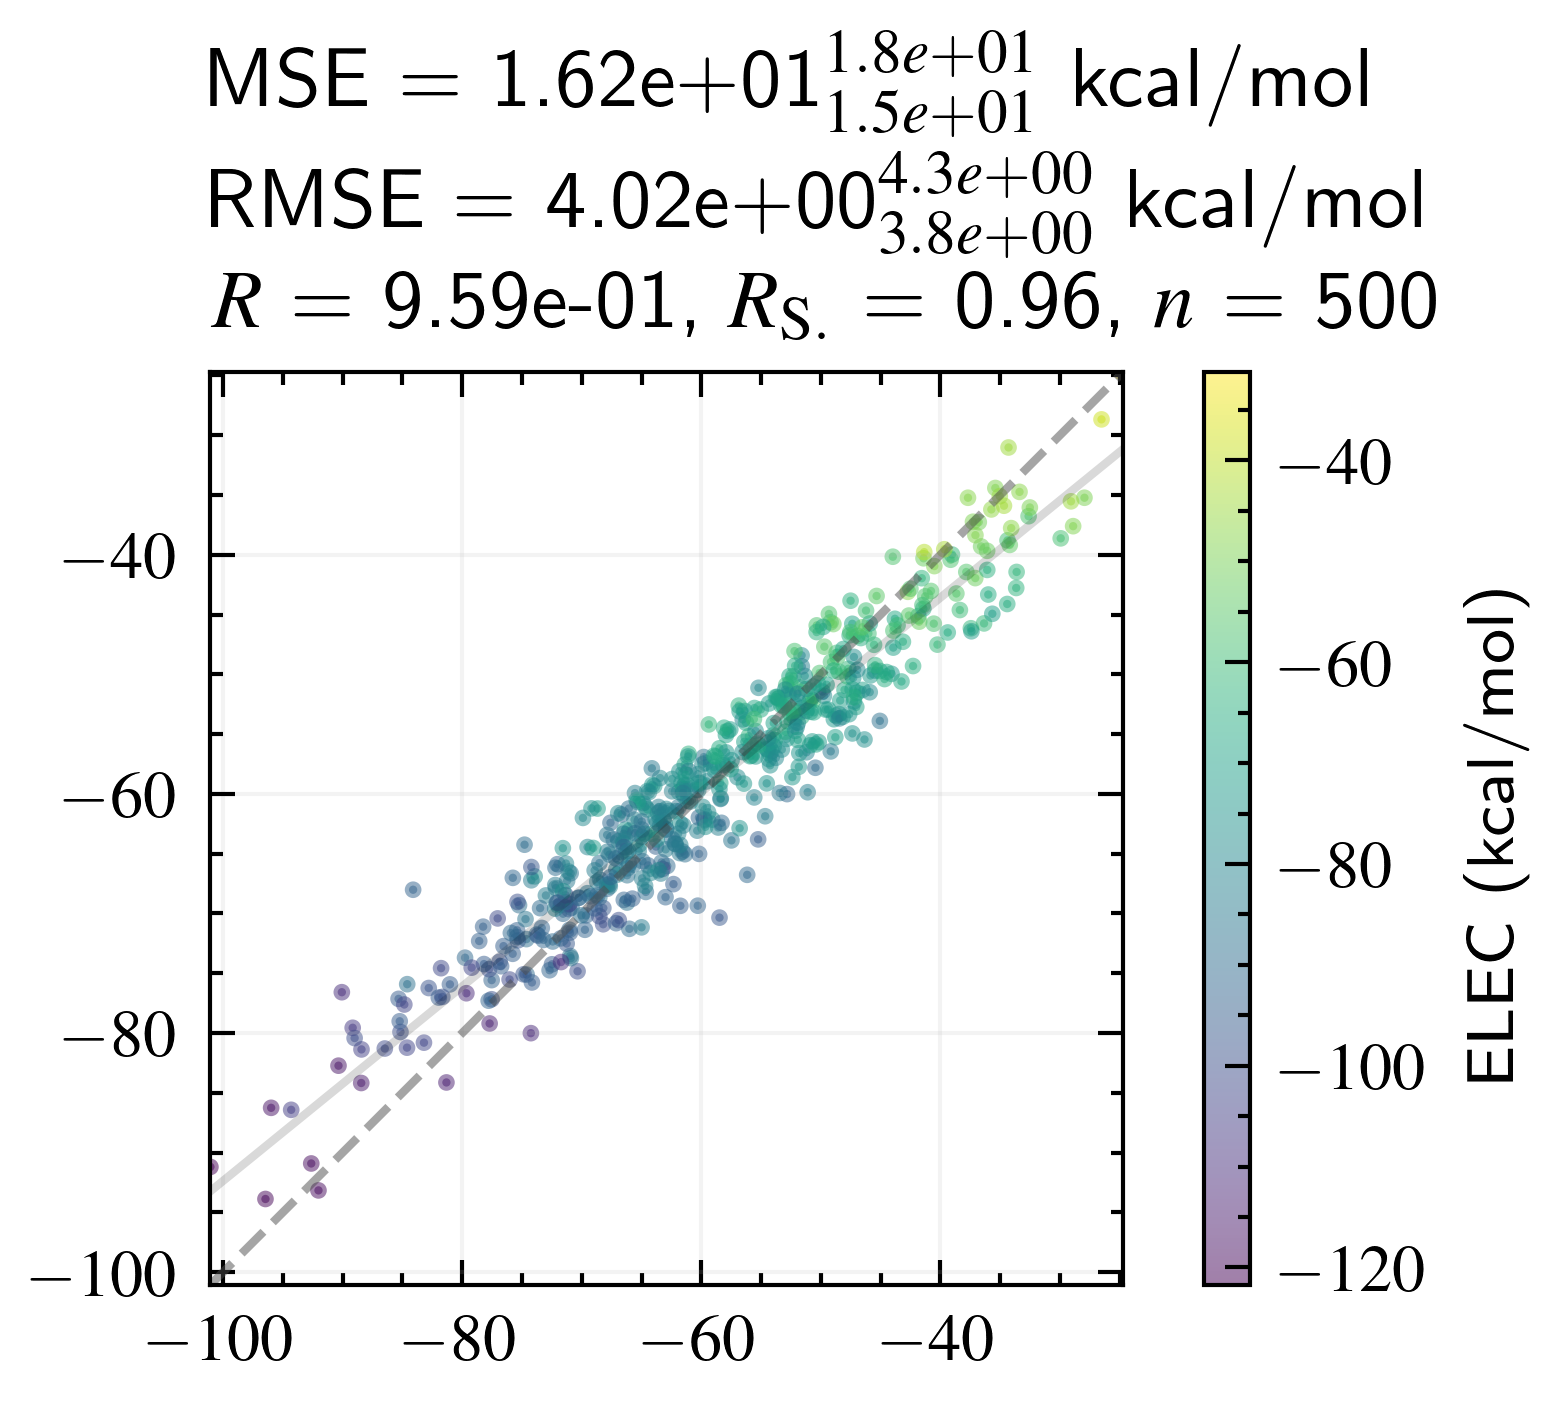

In [26]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data.ELEC

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ELEC")
plt.savefig("kmdcm_harmonic_lj_fit.pdf")


#  LJ fit exact


In [27]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_kmdcm_intE.pkl"))
LJFF

FF: LJ water_cluster ELEC harmonic ECOL (jax_coloumb: True)

In [28]:
# p = PKL_PATH / "water_cluster/pbe0dz/pbe0_dz.pc"
# data_ = Data(p)

In [96]:
LJFF.data

ECOL      KEY     TOTAL       ELEC       VDW      KEY  \
test0   -173.022645    test0  24.14023 -104.54998  20.41138    test0   
test1   -105.096240    test1  25.25058  -63.45565   8.97296    test1   
test2   -144.567121    test2  24.75756  -89.34864  14.41942    test2   
test3   -105.558619    test3  21.75948  -62.57541   5.74741    test3   
test4   -141.957058    test4  21.69034  -90.29468  12.55821    test4   
...             ...      ...       ...        ...       ...      ...   
test495 -156.403481  test495  24.92171  -95.04093  17.54292  test495   
test496 -126.839243  test496  15.65968  -75.31144  12.74644  test496   
test497 -160.377711  test497  20.65947  -90.76807  24.76786  test497   
test498 -154.210967  test498  21.38907  -87.19819  20.35679  test498   
test499 -155.884825  test499  19.75572  -92.65514  21.20638  test499   

            M_ENERGY      KEY  n_monomers     C_ENERGY  ...  C_ENERGY_kcalmol  \
test0   -1527.133263    test0          20 -1527.276175  ...    -958370.381547   
test1   -1527.135387    test1          20 -1527.221635  ...    -958336.157791   
test2   -1527.140946    test2          20 -1527.260418  ...    -958360.493844   
test3   -1527.151295    test3          20 -1527.247454  ...    -958352.359334   
test4   -1527.150321    test4          20 -1527.270835  ...    -958367.030618   
...              ...      ...         ...          ...  ...               ...   
test495 -1527.129876  test495          20 -1527.255655  ...    -958357.505436   
test496 -1527.168887  test496          20 -1527.264530  ...    -958363.074582   
test497 -1527.154064  test497          20 -1527.248923  ...    -958353.280867   
test498 -1527.150078  test498          20 -1527.257280  ...    -958358.525003   
test499 -1527.154292  test499          20 -1527.269832  ...    -958366.401571   

         DUMMY    k   epol_mike  first_order_energy  epol_pairs    fit_ECOL  \
test0        0    0 -197.910658            7.640822 -182.982917 -165.142944   
test1        0    1 -113.959761           -5.902676 -111.406093 -105.509087   
test2        0    2 -160.484782           -6.037152 -153.110225 -157.379913   
test3        0    3 -118.662845           -4.570214 -111.548989 -109.259064   
test4        0    4 -155.773808          -12.251942 -151.839749 -148.200836   
...        ...  ...         ...                 ...         ...         ...   
test495      0  495 -175.806320           -1.718463 -166.329665 -155.439667   
test496      0  496 -138.410126            2.169631 -133.079412 -124.157227   
test497      0  497 -178.929213           31.250204 -170.886865 -170.427658   
test498      0  498 -171.903376           15.363398 -164.288222 -145.085831   
test499      0  499 -176.124065           11.649578 -166.179097 -144.232681   

          fit_intE    pol_dif    foe_pol  
test0   -95.523911 -24.888013 -17.247190  
test1   -52.915920  -8.863521 -14.766197  
test2   -78.676498 -15.917661 -21.954814  
test3   -57.196068 -13.104226 -17.674440  
test4   -78.643959 -13.816750 -26.068692  
...            ...        ...        ...  
test495 -81.613953 -19.402840 -21.121302  
test496 -56.578575 -11.570883  -9.401252  
test497 -61.447281 -18.551502  12.698703  
test498 -62.751503 -17.692409  -2.329011  
test499 -68.822350 -20.239240  -8.589662  

[500 rows x 25 columns]

In [30]:
# data_.monomer_df

array([[<Axes: title={'center': 'pol_dif'}>,
        <Axes: title={'center': 'ECOL'}>],
       [<Axes: title={'center': 'epol_mike'}>,
        <Axes: title={'center': 'first_order_energy'}>],
       [<Axes: title={'center': 'fit_ECOL'}>,
        <Axes: title={'center': 'fit_ECOL_pol'}>]], dtype=object)

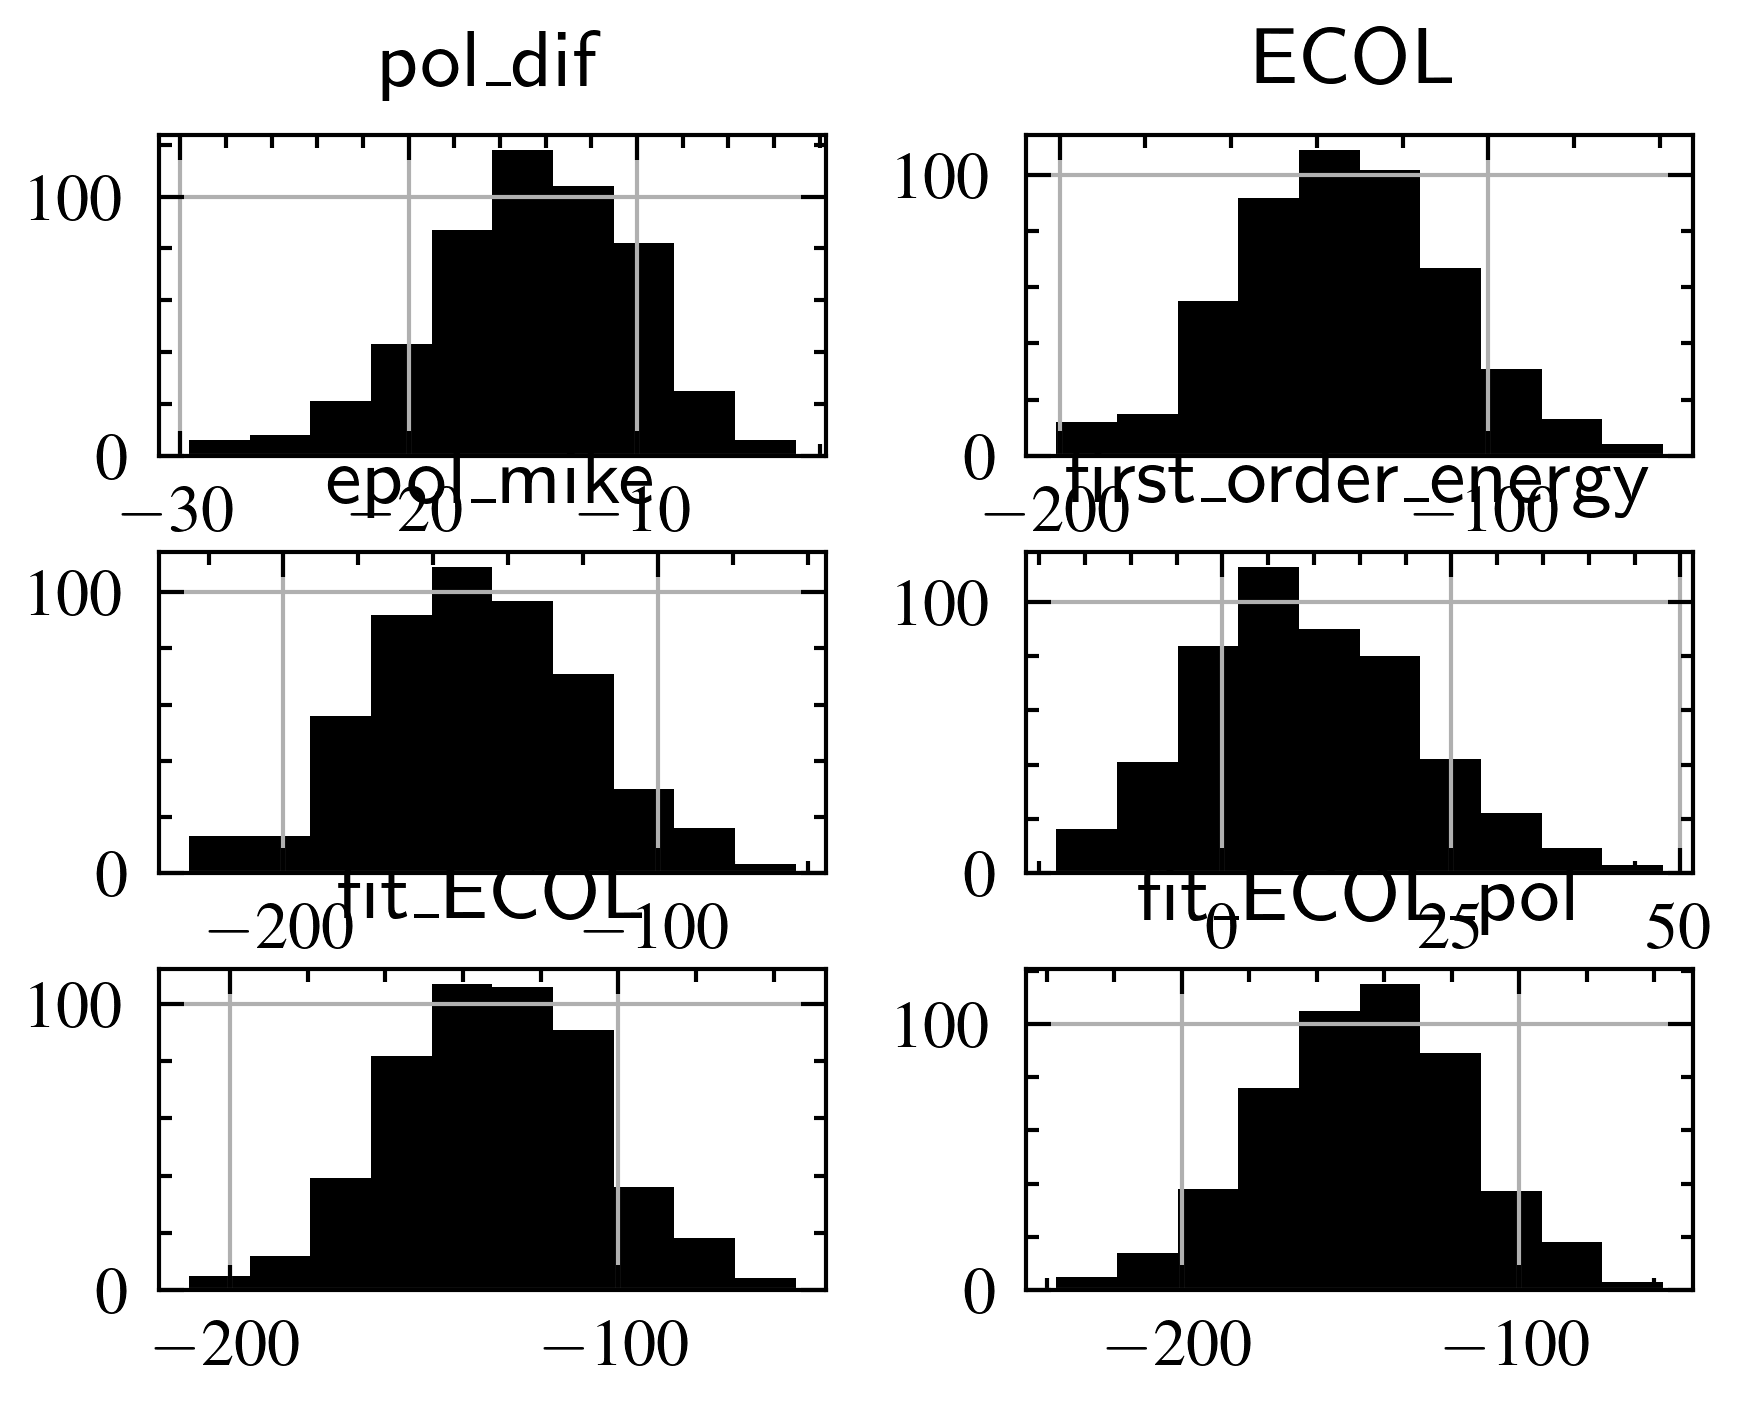

In [149]:
LJFF.data["pol_dif"] =   LJFF.data["epol_mike"] - LJFF.data["ECOL"]
LJFF.data["foe_pol"] = LJFF.data["first_order_energy"] + LJFF.data["pol_dif"]
LJFF.data["fit_ECOL_pol"] = LJFF.data["fit_ECOL"] + LJFF.data["pol_dif"]
LJFF.data["ELEC_pol"] = LJFF.data["ELEC"] + LJFF.data["pol_dif"]
# LJFF.data["pol_dif"].hist()
# LJFF.data["first_order_energy"].hist()
# LJFF.data["ECOL"].hist()
# LJFF.data["epol_mike"].hist()
LJFF.data.hist(["pol_dif", "ECOL", "epol_mike", "first_order_energy", "fit_ECOL", "fit_ECOL_pol"])


4.859650345195513e-122


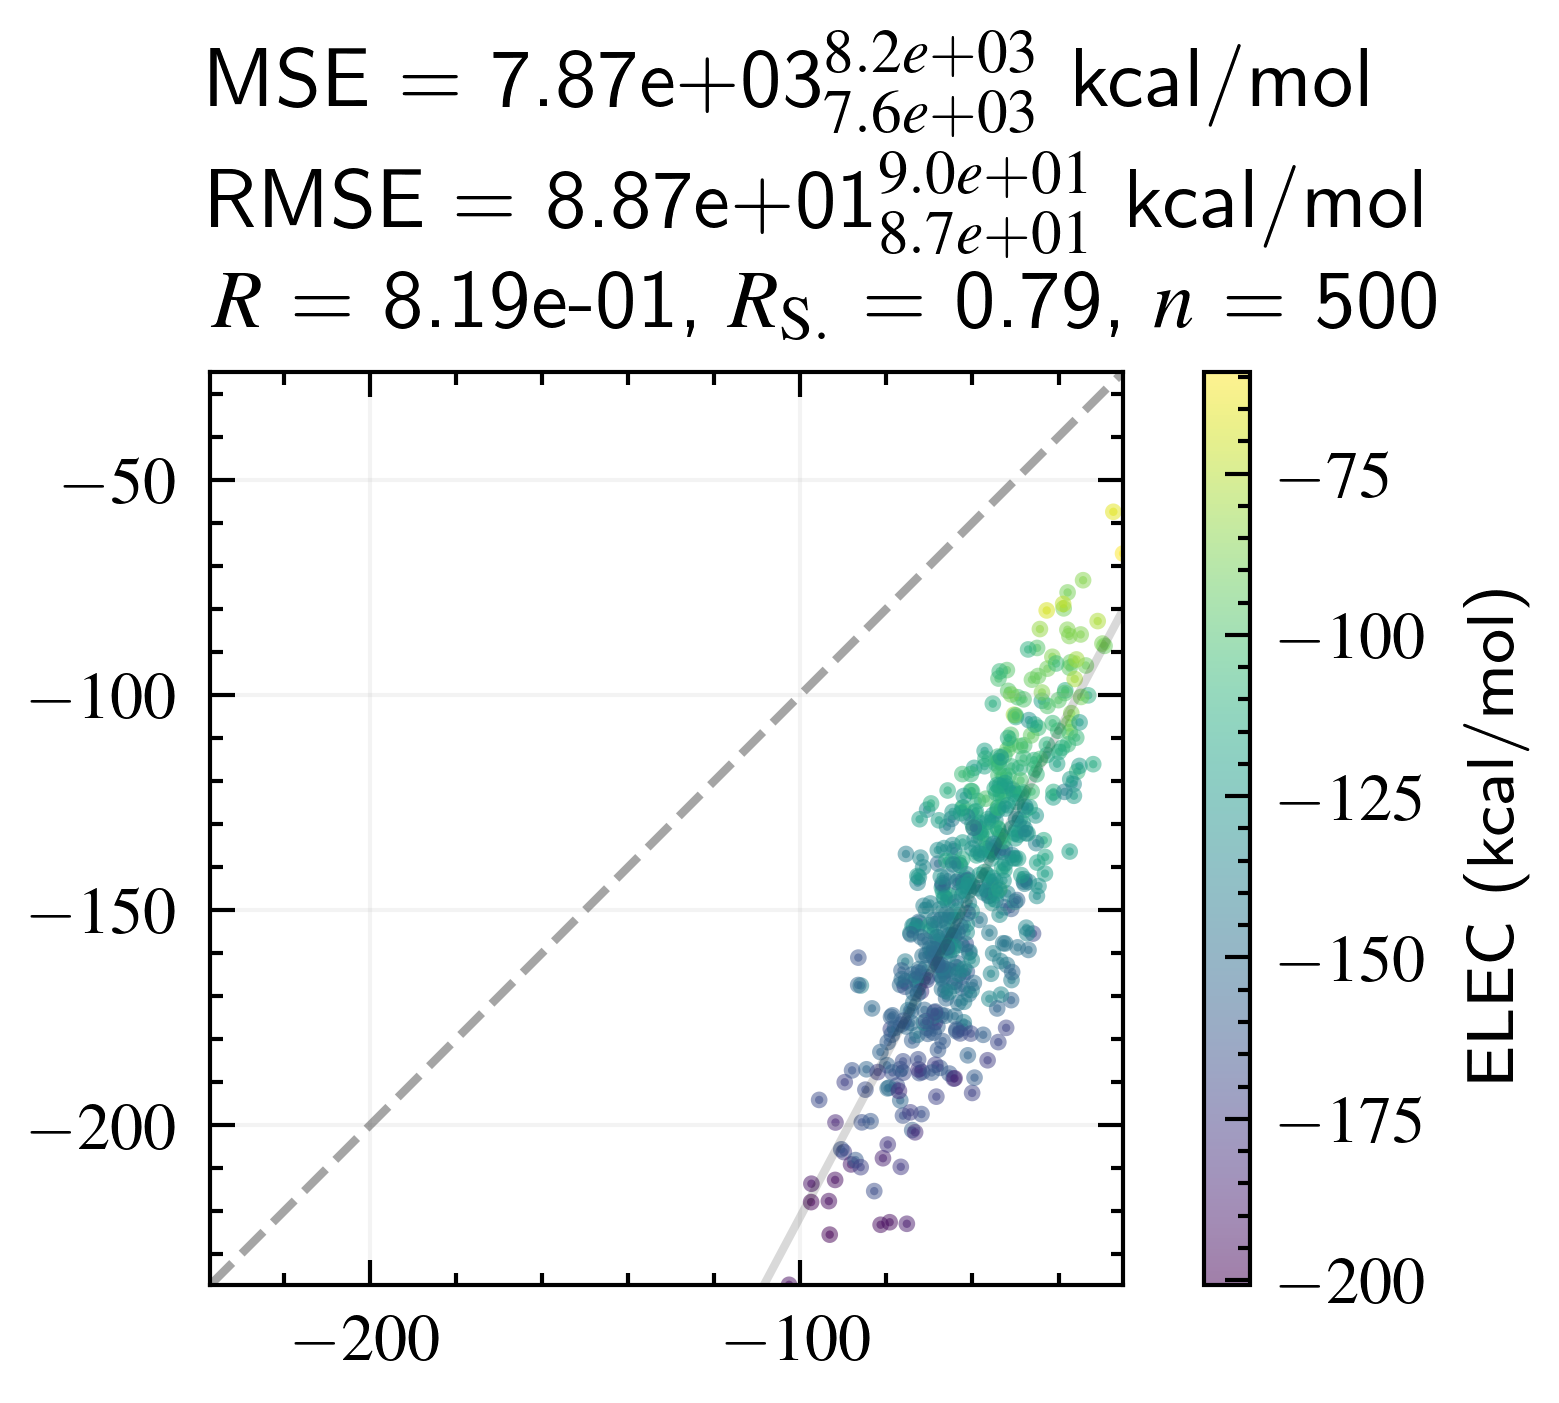

In [150]:
plot_energy_MSE(LJFF.data, "intE", "fit_ECOL_pol",  elec = "ECOL")
plt.savefig("foe_pol_vs_intE.pdf")

In [213]:
LJFF = next(read_from_pickle(f"ff/fit_ECOL_kmdcm_intE.pkl"))

LJFF.data["pol_dif"] =   LJFF.data["epol_mike"] - LJFF.data["ECOL"]
LJFF.data["foe_pol"] = LJFF.data["first_order_energy"] + LJFF.data["pol_dif"]

LJFF.data["fit_ECOL_pol"] = LJFF.data["fit_ECOL"] + LJFF.data["pol_dif"]
LJFF.data["ELEC_pol"] = LJFF.data["ELEC"] + LJFF.data["pol_dif"]

# LJFF.data["pol_dif"].hist()
# LJFF.data["first_order_energy"].hist()
# LJFF.data["ECOL"].hist()
# LJFF.data["epol_mike"].hist()
# LJFF.data.hist(["foe_pol", "intE", "pol_dif", "ECOL", "epol_mike", "first_order_energy"])


LJFF.elec = "ELEC_pol"
LJFF.intE = "intE"
LJFF.intern = "Exact"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

32.597633


FF: LJ water_cluster ELEC_pol Exact intE (jax_coloumb: True)

In [214]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

fun  nit  nfev  status  success  \
0  134.366348  123   312       0     True   

                                 message  \
0  Optimization terminated successfully.   

                                                   x  \
0  [976.4710025989108, 1927.4526069006072, 2000.0...   

                                       final_simplex  
0  ([[976.4710025989108, 1927.4526069006072, 2000...

In [215]:
sig_bound = (0.001, 2.5*5)
ep_bound = (0.001, 2.5*0.1)
chg_bound = (100,2000)

CHGPEN_bound = [(chg_bound),(chg_bound),(chg_bound),(chg_bound),(0,2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), 
            (1, 8), (6, 20))

In [216]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [217]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

fun  nit  nfev  status  success  \
2      6.909043  478   821       0     True   
9      7.513356  179   350       0     True   
4      7.919528  188   357       0     True   
0    134.366348  123   312       0     True   
1   1161.355835   53   143       0     True   
3   1161.355835   44   146       0     True   
5   1161.355835   29   110       0     True   
6   1161.355835   60   162       0     True   
7   1161.355835   43   146       0     True   
8   1161.355835   43   140       0     True   
10  1161.355835   29   110       0     True   

                                  message  \
2   Optimization terminated successfully.   
9   Optimization terminated successfully.   
4   Optimization terminated successfully.   
0   Optimization terminated successfully.   
1   Optimization terminated successfully.   
3   Optimization terminated successfully.   
5   Optimization terminated successfully.   
6   Optimization terminated successfully.   
7   Optimization terminated successfully.   
8   Optimization terminated successfully.   
10  Optimization terminated successfully.   

                                                    x  \
2   [0.6554674977373172, 1.8413517838405329, 0.001...   
9   [0.001, 1.8318177623394778, 0.0166909796361159...   
4   [0.5690856762002373, 1.7901069616240524, 0.001...   
0   [976.4710025989108, 1927.4526069006072, 2000.0...   
1            [0.001, 0.001, 0.25, 0.2121916809940141]   
3           [0.001, 0.001, 0.11658025371916342, 0.25]   
5   [0.01741266205192976, 0.001, 0.132588531068380...   
6   [0.001, 0.016497373353019817, 0.22822293459463...   
7   [0.001, 0.09371984433840508, 0.213414804567634...   
8   [0.001, 0.001, 0.07451146961614716, 0.05689276...   
10  [0.00507372839703054, 0.001, 0.25, 0.228416946...   

                                        final_simplex  
2   ([[0.6554674977373172, 1.8413517838405329, 0.0...  
9   ([[0.001, 1.8318177623394778, 0.01669097963611...  
4   ([[0.5690856762002373, 1.7901069616240524, 0.0...  
0   ([[976.4710025989108, 1927.4526069006072, 2000...  
1   ([[0.001, 0.001, 0.25, 0.2121916809940141], [0...  
3   ([[0.001, 0.001, 0.11658025371916342, 0.25], [...  
5   ([[0.01741266205192976, 0.001, 0.1325885310683...  
6   ([[0.001, 0.016497373353019817, 0.228222934594...  
7   ([[0.001, 0.09371984433840508, 0.2134148045676...  
8   ([[0.001, 0.001, 0.07451146961614716, 0.056892...  
10  ([[0.00507372839703054, 0.001, 0.25, 0.2284169...

In [218]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([6.55467498e-01, 1.84135178e+00, 1.00001304e-03, 1.10651732e-01])

In [219]:
abs(LJFF.eval_jax(bestres)).mean()

Array(32.704582, dtype=float32)

In [220]:
abs(LJFF.targets).mean()

Array(32.597633, dtype=float32)

In [221]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

2.6285059087003693

0.0


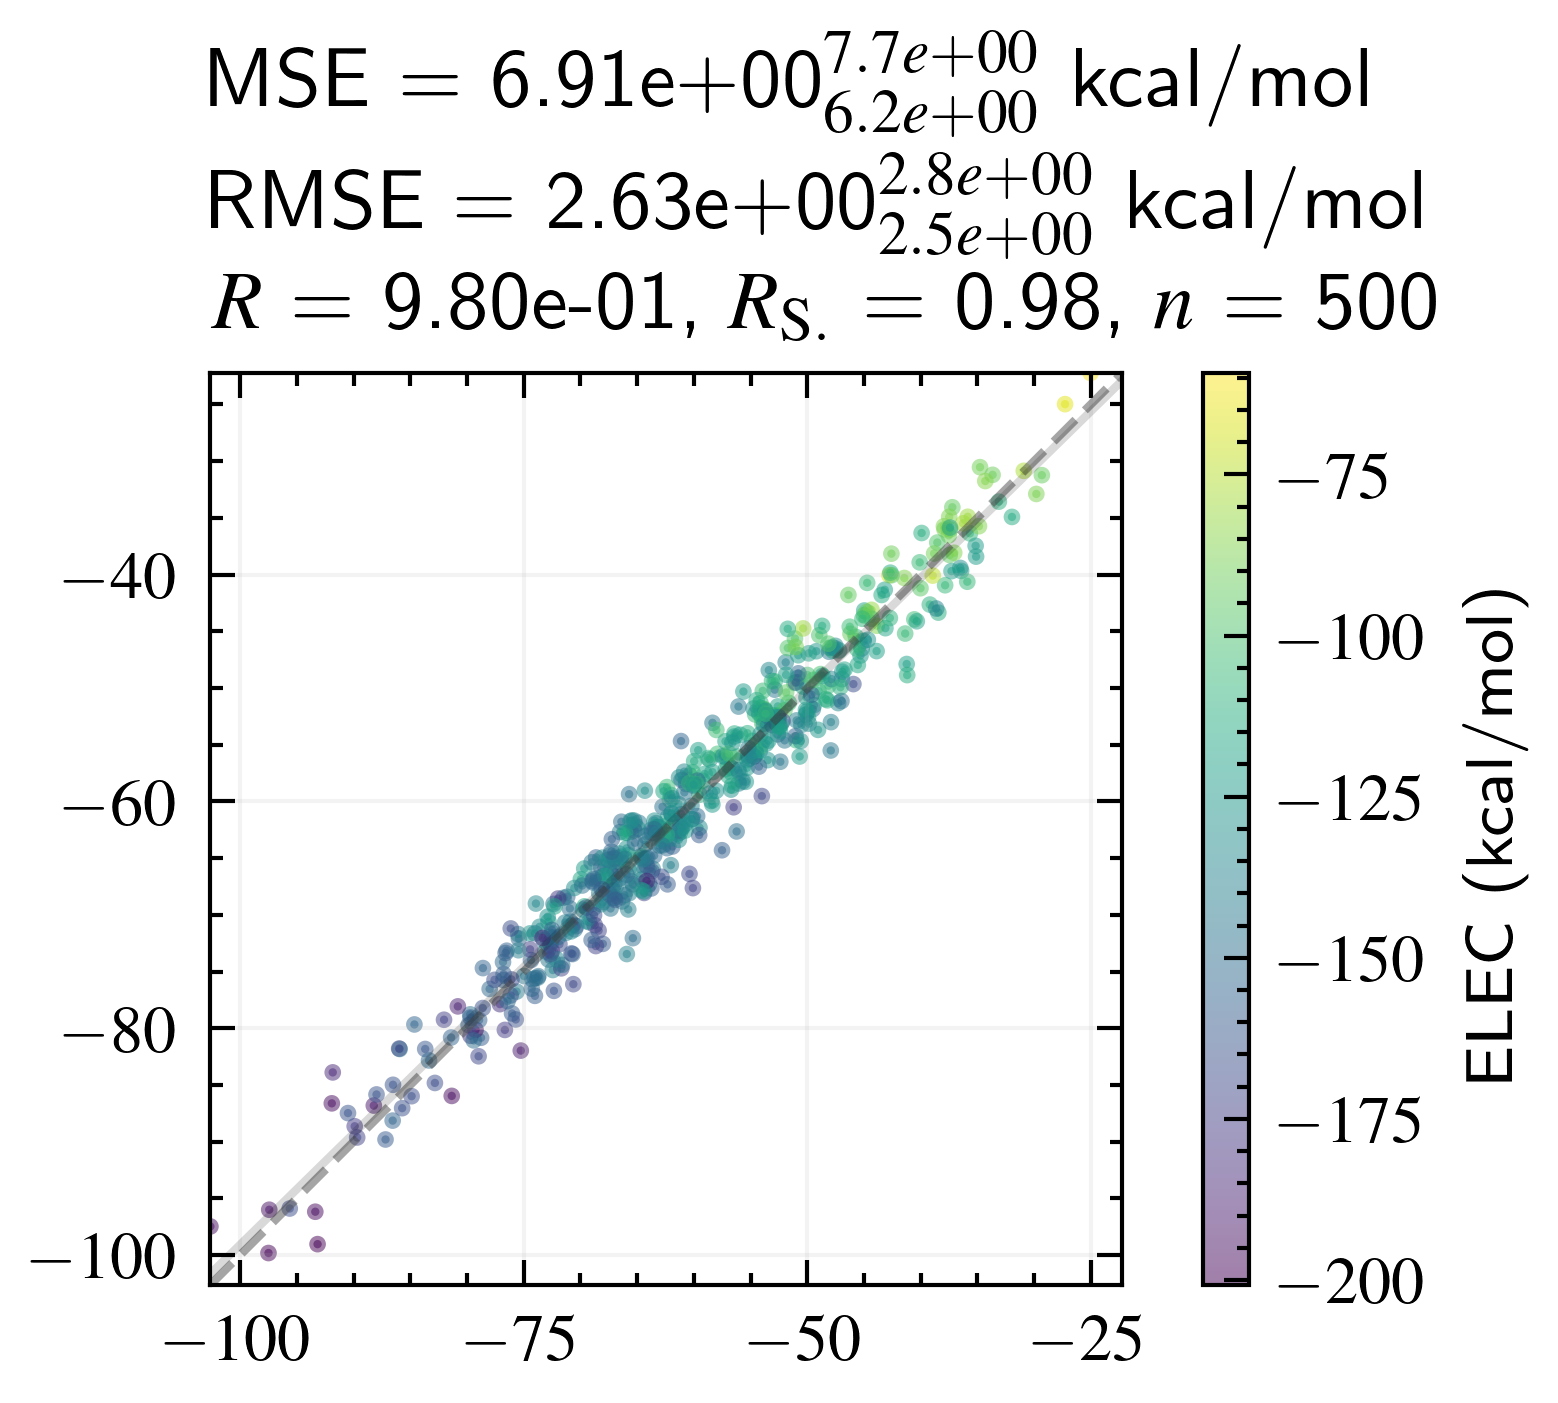

In [222]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data[LJFF.elec]

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ECOL")
plt.savefig("kmdcm_pol_exact_vs_intE.pdf")


In [184]:
LJFF = next(read_from_pickle(f"ff/fit_ECOL_optpc_intE.pkl"))

LJFF.data["pol_dif"] =   LJFF.data["epol_mike"] - LJFF.data["ECOL"]
LJFF.data["foe_pol"] = LJFF.data["first_order_energy"] + LJFF.data["pol_dif"]

LJFF.data["fit_ECOL_pol"] = LJFF.data["fit_ECOL"] + LJFF.data["pol_dif"]
LJFF.data["ELEC_pol"] = LJFF.data["ELEC"] + LJFF.data["pol_dif"]

# LJFF.data["pol_dif"].hist()
# LJFF.data["first_order_energy"].hist()
# LJFF.data["ECOL"].hist()
# LJFF.data["epol_mike"].hist()
# LJFF.data.hist(["foe_pol", "intE", "pol_dif", "ECOL", "epol_mike", "first_order_energy"])


LJFF.elec = "ELEC_pol"
LJFF.intE = "intE"
LJFF.intern = "Exact"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

22.263636


FF: LJ water_cluster ELEC_pol Exact intE (jax_coloumb: True)

In [185]:
sig_bound = (0.001, 2.5*5)
ep_bound = (0.001, 2.5*0.1)
chg_bound = (100,2000)

CHGPEN_bound = [(chg_bound),(chg_bound),(chg_bound),(chg_bound),(0,2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), 
            (1, 8), (6, 20))

In [186]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [187]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

fun  nit  nfev  status  success  \
10   19.045721  231   443       0     True   
8    25.342464  473   825       0     True   
0   205.833069   91   275       0     True   
1   578.913513   57   151       0     True   
2   578.913513   53   156       0     True   
3   578.913513   56   157       0     True   
4   578.913513   54   155       0     True   
5   578.913513   31   106       0     True   
6   578.913513   43   146       0     True   
7   578.913513   49   145       0     True   
9   578.913513   33   118       0     True   

                                  message  \
10  Optimization terminated successfully.   
8   Optimization terminated successfully.   
0   Optimization terminated successfully.   
1   Optimization terminated successfully.   
2   Optimization terminated successfully.   
3   Optimization terminated successfully.   
4   Optimization terminated successfully.   
5   Optimization terminated successfully.   
6   Optimization terminated successfully.   
7   Optimization terminated successfully.   
9   Optimization terminated successfully.   

                                                    x  \
10  [0.18130523708613688, 1.8152175429609378, 0.24...   
8   [1.2937753479257275, 1.7691402804039842, 0.010...   
0   [1001.3579229369614, 1996.8292202356433, 1303....   
1   [0.001, 0.001, 0.24935140395824723, 0.23493243...   
2           [0.001, 0.001, 0.25, 0.08722397366670637]   
3   [0.001, 0.001, 0.24964294692147349, 0.24689597...   
4                          [0.001, 0.001, 0.25, 0.25]   
5   [0.001, 0.001, 0.24842715227262302, 0.24567275...   
6   [0.001, 0.0983206049605636, 0.25, 0.0524276096...   
7           [0.001, 0.001, 0.21856501133203798, 0.25]   
9           [0.001, 0.001, 0.25, 0.23946191075978646]   

                                        final_simplex  
10  ([[0.18130523708613688, 1.8152175429609378, 0....  
8   ([[1.2937753479257275, 1.7691402804039842, 0.0...  
0   ([[1001.3579229369614, 1996.8292202356433, 130...  
1   ([[0.001, 0.001, 0.24935140395824723, 0.234932...  
2   ([[0.001, 0.001, 0.25, 0.08722397366670637], [...  
3   ([[0.001, 0.001, 0.24964294692147349, 0.246895...  
4   ([[0.001, 0.001, 0.25, 0.25], [0.001, 0.001000...  
5   ([[0.001, 0.001, 0.24842715227262302, 0.245672...  
6   ([[0.001, 0.0983206049605636, 0.25, 0.05242760...  
7   ([[0.001, 0.001, 0.21856501133203798, 0.25], [...  
9   ([[0.001, 0.001, 0.25, 0.23946191075978646], [...

In [188]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([0.18130524, 1.81521754, 0.24715666, 0.1300406 ])

In [189]:
abs(LJFF.eval_jax(bestres)).mean()

Array(22.360226, dtype=float32)

In [190]:
abs(LJFF.targets).mean()

Array(22.263636, dtype=float32)

In [191]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

4.364140356825975

9.004279451850626e-242


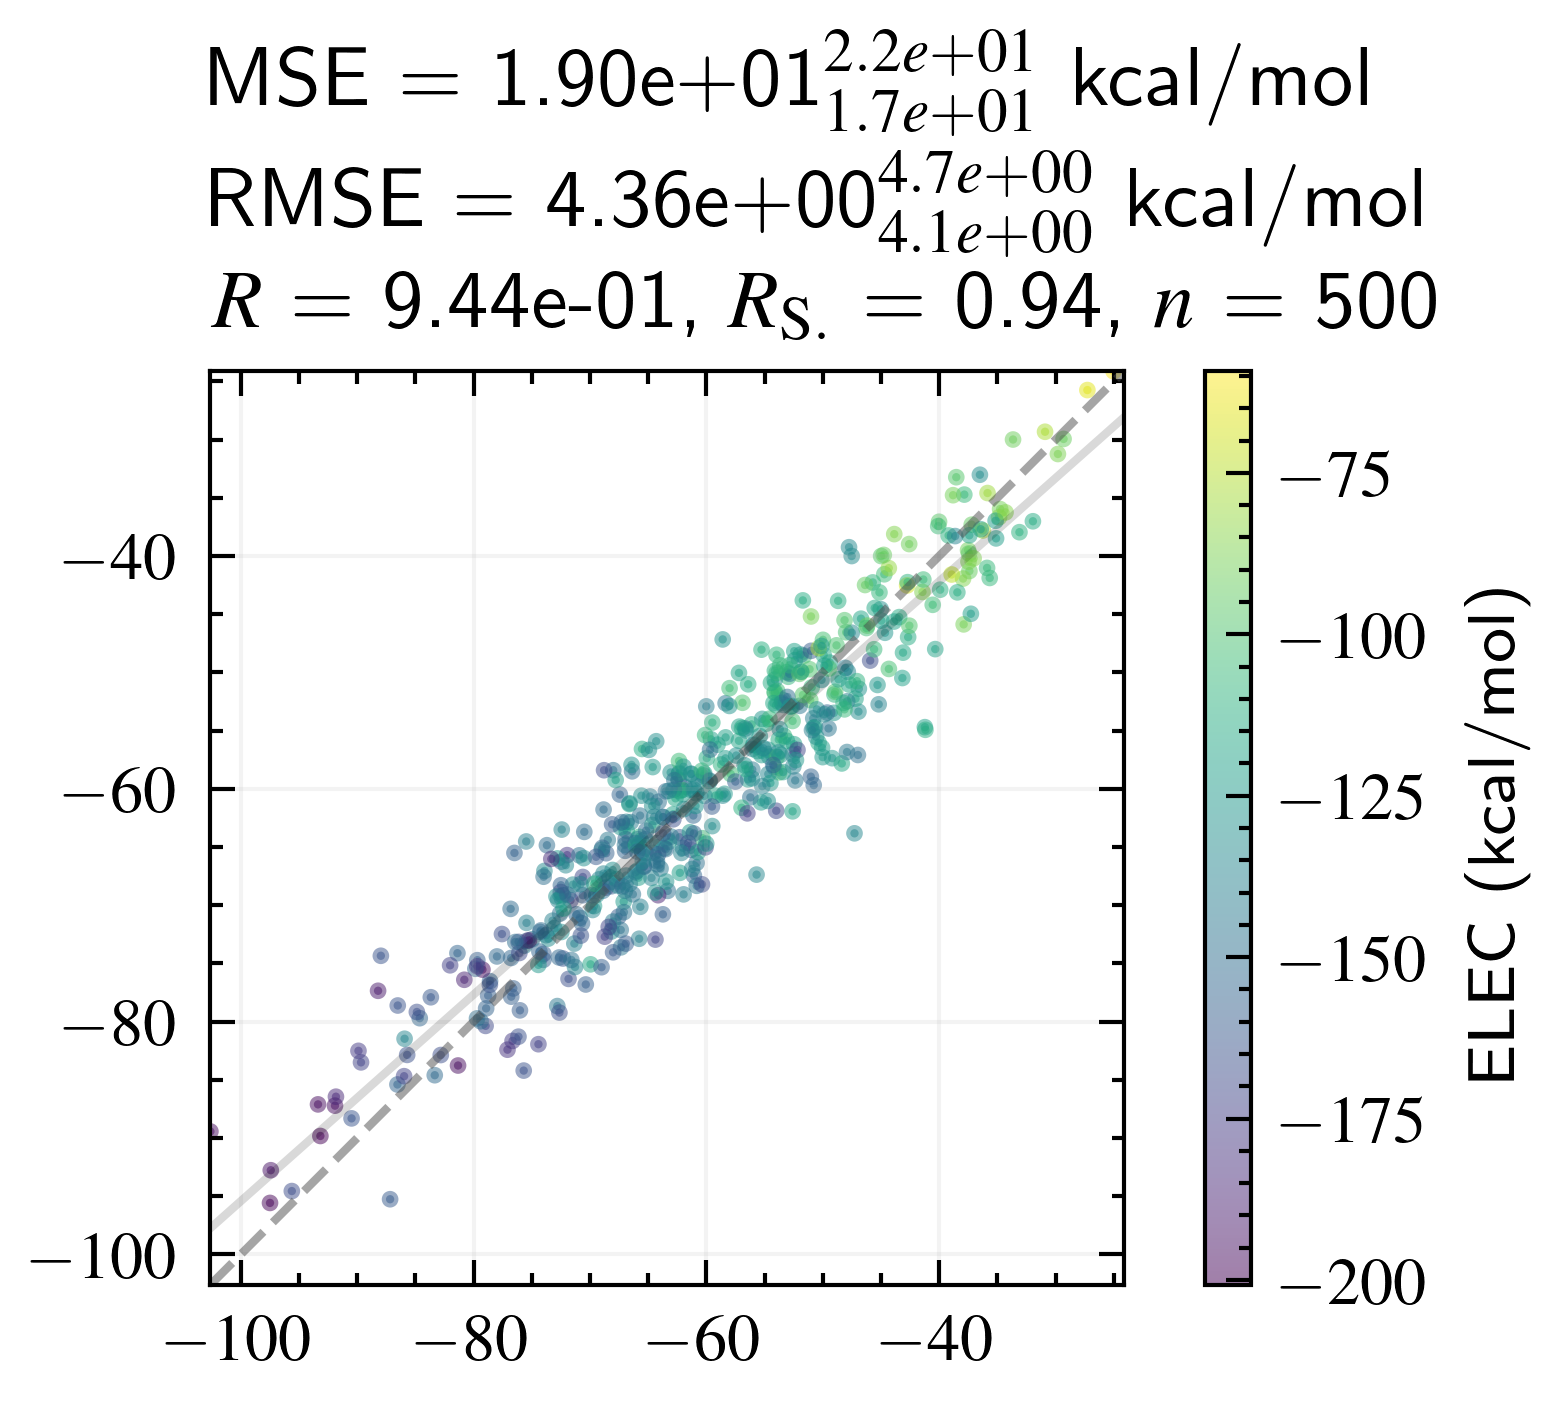

In [192]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data[LJFF.elec]

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ECOL")
plt.savefig("optpc_pol_exact_vs_intE.pdf")


In [194]:
LJFF = next(read_from_pickle(f"ff/fit_ECOL_mdcm_intE.pkl"))

LJFF.data["pol_dif"] =   LJFF.data["epol_mike"] - LJFF.data["ECOL"]
LJFF.data["foe_pol"] = LJFF.data["first_order_energy"] + LJFF.data["pol_dif"]

LJFF.data["fit_ECOL_pol"] = LJFF.data["fit_ECOL"] + LJFF.data["pol_dif"]
LJFF.data["ELEC_pol"] = LJFF.data["ELEC"] + LJFF.data["pol_dif"]

# LJFF.data["pol_dif"].hist()
# LJFF.data["first_order_energy"].hist()
# LJFF.data["ECOL"].hist()
# LJFF.data["epol_mike"].hist()
# LJFF.data.hist(["foe_pol", "intE", "pol_dif", "ECOL", "epol_mike", "first_order_energy"])


LJFF.elec = "ELEC_pol"
LJFF.intE = "intE"
LJFF.intern = "Exact"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

35.3149


FF: LJ water_cluster ELEC_pol Exact intE (jax_coloumb: True)

In [195]:
sig_bound = (0.001, 2.5*5)
ep_bound = (0.001, 2.5*0.1)
chg_bound = (100,2000)

CHGPEN_bound = [(chg_bound),(chg_bound),(chg_bound),(chg_bound),(0,2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), 
            (1, 8), (6, 20))

In [196]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [197]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

fun  nit  nfev  status  success  \
7     10.056029  212   410       0     True   
8     10.066950  421   744       0     True   
4     27.949312  256   476       0     True   
0    134.035934  111   281       0     True   
1   1359.047852   41   128       0     True   
2   1359.047852   43   146       0     True   
3   1359.047852   51   145       0     True   
5   1359.047852   41    69       0     True   
6   1359.047852   33   117       0     True   
9   1359.047852   53   138       0     True   
10  1359.047852   43   145       0     True   

                                  message  \
7   Optimization terminated successfully.   
8   Optimization terminated successfully.   
4   Optimization terminated successfully.   
0   Optimization terminated successfully.   
1   Optimization terminated successfully.   
2   Optimization terminated successfully.   
3   Optimization terminated successfully.   
5   Optimization terminated successfully.   
6   Optimization terminated successfully.   
9   Optimization terminated successfully.   
10  Optimization terminated successfully.   

                                                    x  \
7   [0.0014446126497624499, 1.8889452978576657, 0....   
8   [0.001, 1.8709387734815877, 0.1354185859202796...   
4   [1.6547624884477496, 1.1952692167967953, 0.001...   
0   [1895.8678696937782, 1428.0571930052483, 425.0...   
1   [0.001, 0.001, 0.04201461985525973, 0.01617283...   
2   [0.001, 0.1001993552967071, 0.1090390341656361...   
3           [0.001, 0.001, 0.04612456733407738, 0.25]   
5                        [0.001, 0.001, 0.001, 0.001]   
6   [0.001, 0.001, 0.2395275408270009, 0.017157525...   
9   [0.001, 0.001, 0.24584740307500152, 0.24005001...   
10  [0.001, 0.001, 0.07288025750630012, 0.04068179...   

                                        final_simplex  
7   ([[0.0014446126497624499, 1.8889452978576657, ...  
8   ([[0.001, 1.8709387734815877, 0.13541858592027...  
4   ([[1.6547624884477496, 1.1952692167967953, 0.0...  
0   ([[1895.8678696937782, 1428.0571930052483, 425...  
1   ([[0.001, 0.001, 0.04201461985525973, 0.016172...  
2   ([[0.001, 0.1001993552967071, 0.10903903416563...  
3   ([[0.001, 0.001, 0.04612456733407738, 0.25], [...  
5   ([[0.001, 0.001, 0.001, 0.001], [0.001, 0.001,...  
6   ([[0.001, 0.001, 0.2395275408270009, 0.0171575...  
9   ([[0.001, 0.001, 0.24584740307500152, 0.240050...  
10  ([[0.001, 0.001, 0.07288025750630012, 0.040681...

In [198]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([1.44461265e-03, 1.88894530e+00, 2.50000000e-01, 9.91043639e-02])

In [199]:
abs(LJFF.eval_jax(bestres)).mean()

Array(35.40773, dtype=float32)

In [200]:
abs(LJFF.targets).mean()

Array(35.3149, dtype=float32)

In [201]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

3.171124299008663

2.884025526e-313


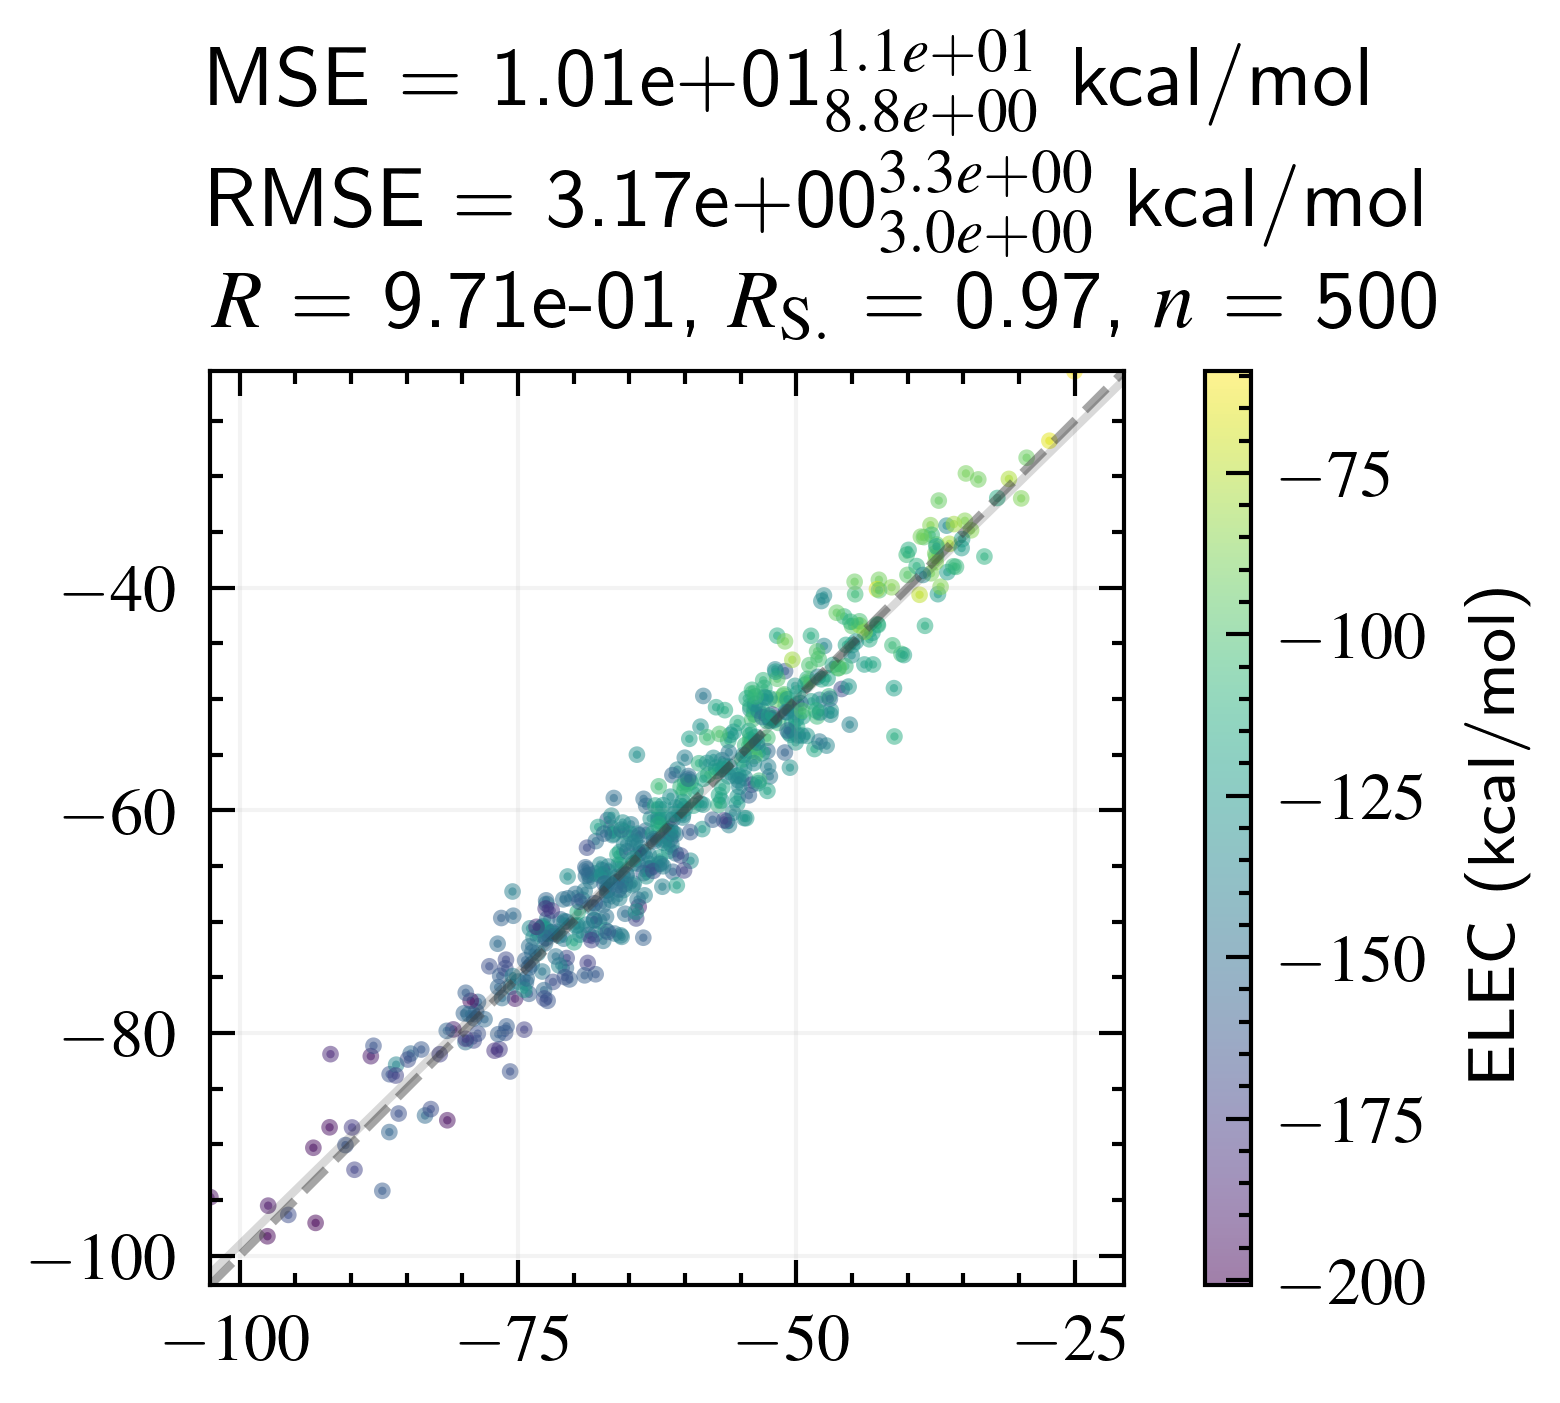

In [202]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data[LJFF.elec]

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ECOL")
plt.savefig("mdcm_pol_exact_vs_intE.pdf")


In [203]:
LJFF = next(read_from_pickle(f"ff/fit_ECOL_tip3_intE.pkl"))

LJFF.data["pol_dif"] =   LJFF.data["epol_mike"] - LJFF.data["ECOL"]
LJFF.data["foe_pol"] = LJFF.data["first_order_energy"] + LJFF.data["pol_dif"]

LJFF.data["fit_ECOL_pol"] = LJFF.data["fit_ECOL"] + LJFF.data["pol_dif"]
LJFF.data["ELEC_pol"] = LJFF.data["ELEC"] + LJFF.data["pol_dif"]

# LJFF.data["pol_dif"].hist()
# LJFF.data["first_order_energy"].hist()
# LJFF.data["ECOL"].hist()
# LJFF.data["epol_mike"].hist()
# LJFF.data.hist(["foe_pol", "intE", "pol_dif", "ECOL", "epol_mike", "first_order_energy"])


LJFF.elec = "ELEC_pol"
LJFF.intE = "intE"
LJFF.intern = "Exact"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

57.70033


FF: LJ water_cluster ELEC_pol Exact intE (jax_coloumb: True)

In [ ]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

In [204]:
sig_bound = (0.001, 2.5*5)
ep_bound = (0.001, 2.5*0.1)
chg_bound = (100,2000)

CHGPEN_bound = [(chg_bound),(chg_bound),(chg_bound),(chg_bound),(0,2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), 
            (1, 8), (6, 20))

In [205]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [206]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

fun  nit  nfev  status  success  \
2     28.236765  803  1366       0     True   
1     28.339695  729  1278       0     True   
9     28.616304  514   925       0     True   
7     28.621561  508   896       0     True   
3     29.921009  373   667       0     True   
0     95.599068  107   280       0     True   
4   3536.979492   20    34       0     True   
5   3536.979492   50   147       0     True   
6   3536.979492   39   126       0     True   
8   3536.979492   43   140       0     True   
10  3536.979492   35   130       0     True   

                                  message  \
2   Optimization terminated successfully.   
1   Optimization terminated successfully.   
9   Optimization terminated successfully.   
7   Optimization terminated successfully.   
3   Optimization terminated successfully.   
0   Optimization terminated successfully.   
4   Optimization terminated successfully.   
5   Optimization terminated successfully.   
6   Optimization terminated successfully.   
8   Optimization terminated successfully.   
10  Optimization terminated successfully.   

                                                    x  \
2   [0.001, 2.660966074815207, 0.05899490900931832...   
1   [0.001, 2.4930047259743002, 0.1254476980566445...   
9   [0.001, 2.363122218920699, 0.2480081601852956,...   
7   [0.001, 2.3622540662764044, 0.25, 0.0058379568...   
3   [0.001, 2.045354596128836, 0.001, 0.0446327088...   
0   [174.23542804067517, 1953.2216908086712, 627.6...   
4                          [0.001, 0.001, 0.25, 0.25]   
5   [0.001, 0.001, 0.20062289679821171, 0.02725668...   
6           [0.001, 0.001, 0.20087291652288375, 0.25]   
8   [0.001, 0.001, 0.07463440210649422, 0.24579381...   
10          [0.001, 0.001, 0.19610526866248484, 0.25]   

                                        final_simplex  
2   ([[0.001, 2.660966074815207, 0.058994909009318...  
1   ([[0.001, 2.4930047259743002, 0.12544769805664...  
9   ([[0.001, 2.363122218920699, 0.248008160185295...  
7   ([[0.001, 2.3622540662764044, 0.25, 0.00583795...  
3   ([[0.001, 2.045354596128836, 0.001, 0.04463270...  
0   ([[174.23542804067517, 1953.2216908086712, 627...  
4   ([[0.001, 0.001, 0.25, 0.25], [0.001, 0.001, 0...  
5   ([[0.001, 0.001, 0.20062289679821171, 0.027256...  
6   ([[0.001, 0.001, 0.20087291652288375, 0.25], [...  
8   ([[0.001, 0.001, 0.07463440210649422, 0.245793...  
10  ([[0.001, 0.001, 0.19610526866248484, 0.25], [...

In [207]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([1.00000000e-03, 2.66096607e+00, 5.89949090e-02, 1.24711794e-03])

In [208]:
abs(LJFF.eval_jax(bestres)).mean()

Array(57.788902, dtype=float32)

In [209]:
abs(LJFF.targets).mean()

Array(57.70033, dtype=float32)

In [210]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

5.313827707767435

3.920037316429241e-237


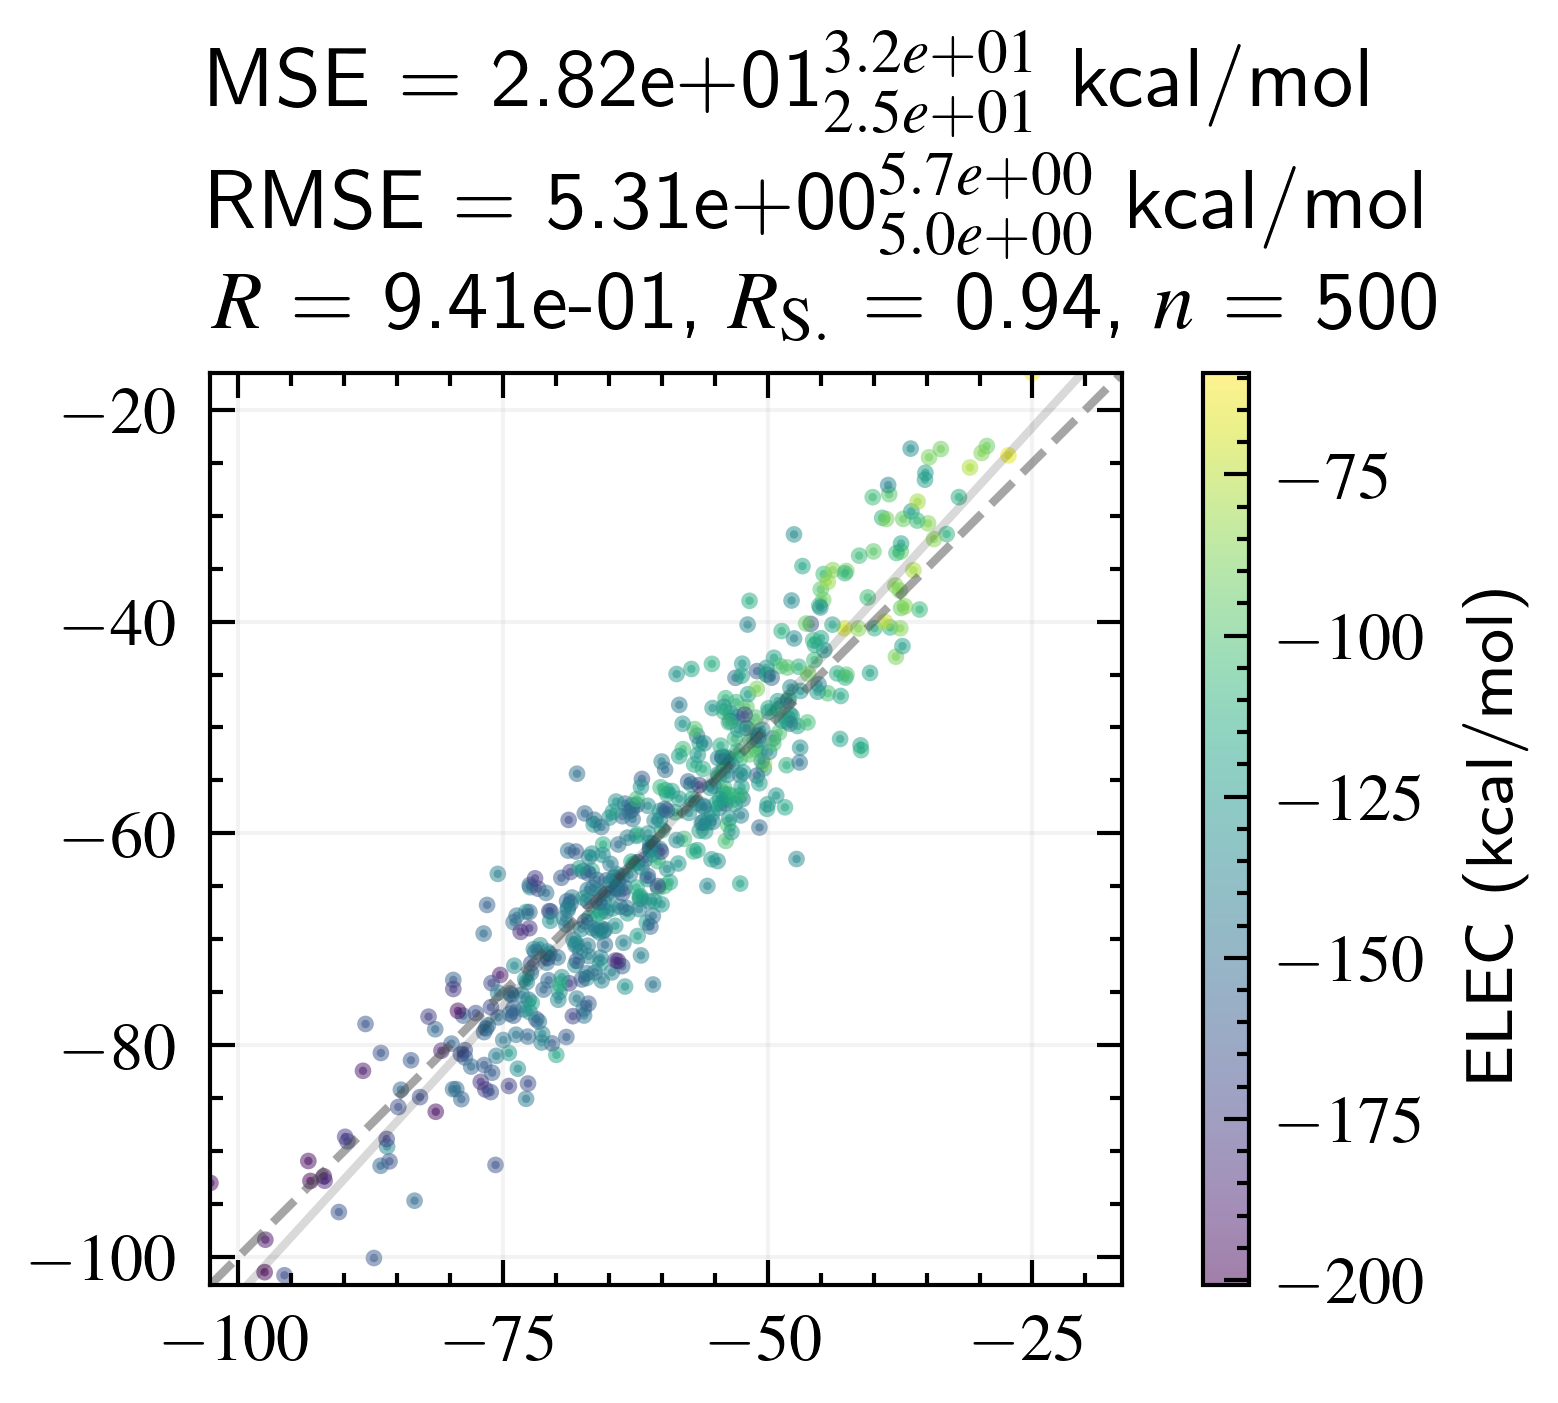

In [212]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data[LJFF.elec]

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ECOL")
plt.savefig("tip3_pol_exact_vs_intE.pdf")


In [193]:
# LJFF.elec = "fit_ECOL"
# LJFF.intE = "intE"
# LJFF.set_intE()
# LJFF.set_targets()
# print(LJFF.targets.mean())
# LJFF

#  LJ fit exact, ECOL


In [40]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_kmdcm_intE.pkl"))
LJFF

FF: LJ water_cluster ELEC harmonic ECOL (jax_coloumb: True)

In [53]:
# p = PKL_PATH / "water_cluster/pbe0dz/pbe0_dz.pc"
# data_ = Data(p)

In [54]:
# data_.data

In [55]:
# data_.monomer_df

In [56]:
# LJFF.data

In [41]:
LJFF.elec = "ECOL"
LJFF.intE = "intE"
LJFF.intern = "Exact"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

73.60582


FF: LJ water_cluster ECOL Exact intE (jax_coloumb: True)

In [97]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [98]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

fun  nit  nfev  status  success  \
7     21.204657  163   321       0     True   
4     21.260790  605  1060       0     True   
8     21.832388  527   906       0     True   
9     21.859806  323   607       0     True   
0    134.035934  111   281       0     True   
1   5713.072266   19    33       0     True   
2   5713.072266   33   134       0     True   
3   5713.072266   51   162       0     True   
5   5713.072266   55   168       0     True   
6   5713.072266   60   179       0     True   
10  5713.072266   32   128       0     True   

                                  message  \
7   Optimization terminated successfully.   
4   Optimization terminated successfully.   
8   Optimization terminated successfully.   
9   Optimization terminated successfully.   
0   Optimization terminated successfully.   
1   Optimization terminated successfully.   
2   Optimization terminated successfully.   
3   Optimization terminated successfully.   
5   Optimization terminated successfully.   
6   Optimization terminated successfully.   
10  Optimization terminated successfully.   

                                                    x  \
7   [0.001, 2.5, 0.052442977704893985, 0.003771101...   
4   [0.001, 2.3104235567465556, 0.1024306623776748...   
8   [0.04807575809023806, 2.115189994996074, 0.001...   
9   [0.008884348351164662, 2.11077471676927, 0.001...   
0   [1895.8678696937782, 1428.0571930052483, 425.0...   
1                            [0.001, 0.001, 2.5, 2.5]   
2   [0.016834891157025612, 0.001, 2.22797180421986...   
3   [0.04010428875422828, 0.05711073632754016, 2.3...   
5   [0.04888373381270443, 0.001, 2.492284599365157...   
6   [0.04744973906828187, 0.04480420986732092, 1.5...   
10  [0.04259229227738264, 0.07410185831495641, 2.5...   

                                        final_simplex  
7   ([[0.001, 2.5, 0.052442977704893985, 0.0037711...  
4   ([[0.001, 2.3104235567465556, 0.10243066237767...  
8   ([[0.04807575809023806, 2.115189994996074, 0.0...  
9   ([[0.008884348351164662, 2.11077471676927, 0.0...  
0   ([[1895.8678696937782, 1428.0571930052483, 425...  
1   ([[0.001, 0.001, 2.5, 2.5], [0.001, 0.001, 2.5...  
2   ([[0.016834891157025612, 0.001, 2.227971804219...  
3   ([[0.04010428875422828, 0.05711073632754016, 2...  
5   ([[0.04888373381270443, 0.001, 2.4922845993651...  
6   ([[0.04744973906828187, 0.04480420986732092, 1...  
10  ([[0.04259229227738264, 0.07410185831495641, 2...

In [99]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([1.00000000e-03, 2.50000000e+00, 5.24429777e-02, 3.77110140e-03])

In [100]:
abs(LJFF.eval_jax(bestres)).mean()

Array(73.67436, dtype=float32)

In [101]:
abs(LJFF.targets).mean()

Array(73.60582, dtype=float32)

In [102]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

4.604851420073415

3.7472721982508165e-230


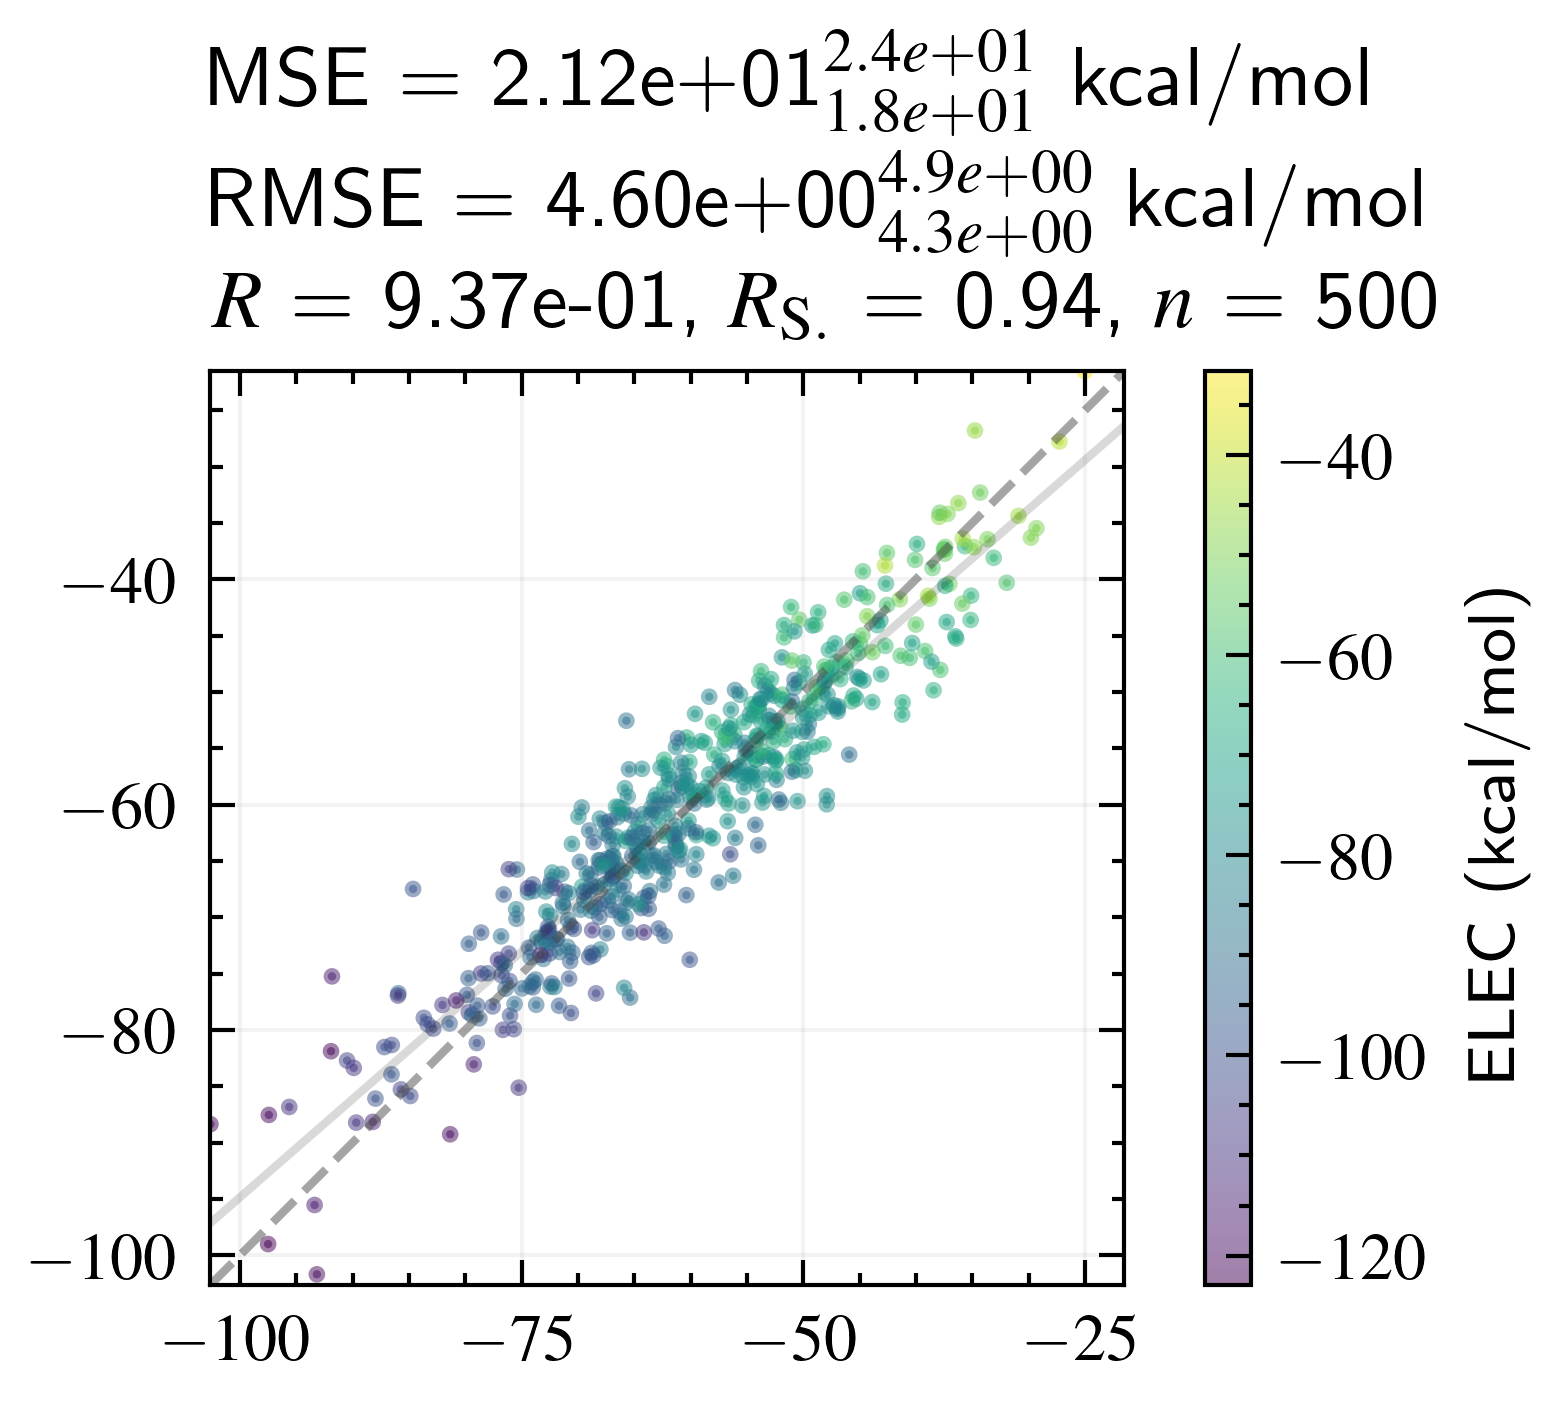

In [103]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data.ECOL

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ELEC")
plt.savefig("ecol_exact_lj_fit.pdf")


In [223]:
LJFF = next(read_from_pickle(f"ff/fit_ECOL_kmdcm_intE.pkl"))

LJFF.data["pol_dif"] =   LJFF.data["epol_mike"] - LJFF.data["ECOL"]
LJFF.data["foe_pol"] = LJFF.data["first_order_energy"] + LJFF.data["pol_dif"]

LJFF.data["fit_ECOL_pol"] = LJFF.data["fit_ECOL"] + LJFF.data["pol_dif"]
LJFF.data["ELEC_pol"] = LJFF.data["ELEC"] + LJFF.data["pol_dif"]

# LJFF.data["pol_dif"].hist()
# LJFF.data["first_order_energy"].hist()
# LJFF.data["ECOL"].hist()
# LJFF.data["epol_mike"].hist()
# LJFF.data.hist(["foe_pol", "intE", "pol_dif", "ECOL", "epol_mike", "first_order_energy"])


LJFF.elec = "epol_mike"
LJFF.intE = "intE"
LJFF.intern = "Exact"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

88.23172


FF: LJ water_cluster epol_mike Exact intE (jax_coloumb: True)

In [224]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

fun  nit  nfev  status  success  \
0  134.366348  123   312       0     True   

                                 message  \
0  Optimization terminated successfully.   

                                                   x  \
0  [976.4710025989108, 1927.4526069006072, 2000.0...   

                                       final_simplex  
0  ([[976.4710025989108, 1927.4526069006072, 2000...

In [225]:
sig_bound = (0.001, 2.5*5)
ep_bound = (0.001, 2.5*0.1)
chg_bound = (100,2000)

CHGPEN_bound = [(chg_bound),(chg_bound),(chg_bound),(chg_bound),(0,2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), 
            (1, 8), (6, 20))

In [226]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [227]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

fun   nit  nfev  status  success  \
7     16.634892   547   962       0     True   
1     16.799688  1352  2274       0     True   
4     16.938118   363   670       0     True   
9     17.095011   575  1014       0     True   
2     17.846655   423   764       0     True   
6     18.163507   699  1222       0     True   
3     19.431517   340   636       0     True   
0    134.366348   123   312       0     True   
5   8202.331055    43   135       0     True   
8   8202.331055    32   112       0     True   
10  8202.331055    31   122       0     True   

                                  message  \
7   Optimization terminated successfully.   
1   Optimization terminated successfully.   
4   Optimization terminated successfully.   
9   Optimization terminated successfully.   
2   Optimization terminated successfully.   
6   Optimization terminated successfully.   
3   Optimization terminated successfully.   
0   Optimization terminated successfully.   
5   Optimization terminated successfully.   
8   Optimization terminated successfully.   
10  Optimization terminated successfully.   

                                                    x  \
7   [0.45832076797892246, 2.7205733625876447, 0.00...   
1   [0.001, 2.8112551174212452, 0.0275839578905192...   
4   [0.5664754924230141, 2.2821638988918074, 0.001...   
9   [0.001, 2.572062871560916, 0.04695271354577098...   
2   [0.0013644234796568895, 2.3790156458351817, 0....   
6   [0.001, 2.348708791084259, 0.25, 0.00989063774...   
3   [0.026438242037745162, 2.166904483302768, 0.00...   
0   [976.4710025989108, 1927.4526069006072, 2000.0...   
5            [0.001, 0.001, 0.25, 0.1453454995765282]   
8           [0.001, 0.001, 0.25, 0.24002442576465455]   
10  [0.05008760894884334, 0.00428820521980766, 0.2...   

                                        final_simplex  
7   ([[0.45832076797892246, 2.7205733625876447, 0....  
1   ([[0.001, 2.8112551174212452, 0.02758395789051...  
4   ([[0.5664754924230141, 2.2821638988918074, 0.0...  
9   ([[0.001, 2.572062871560916, 0.046952713545770...  
2   ([[0.0013644234796568895, 2.3790156458351817, ...  
6   ([[0.001, 2.348708791084259, 0.25, 0.009890637...  
3   ([[0.026438242037745162, 2.166904483302768, 0....  
0   ([[976.4710025989108, 1927.4526069006072, 2000...  
5   ([[0.001, 0.001, 0.25, 0.1453454995765282], [0...  
8   ([[0.001, 0.001, 0.25, 0.24002442576465455], [...  
10  ([[0.05008760894884334, 0.00428820521980766, 0...

In [228]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([4.58320768e-01, 2.72057336e+00, 1.00000000e-03, 1.46731876e-03])

In [229]:
abs(LJFF.eval_jax(bestres)).mean()

Array(88.368256, dtype=float32)

In [230]:
abs(LJFF.targets).mean()

Array(88.23172, dtype=float32)

In [231]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

4.078589401988115

4.136653861820271e-274


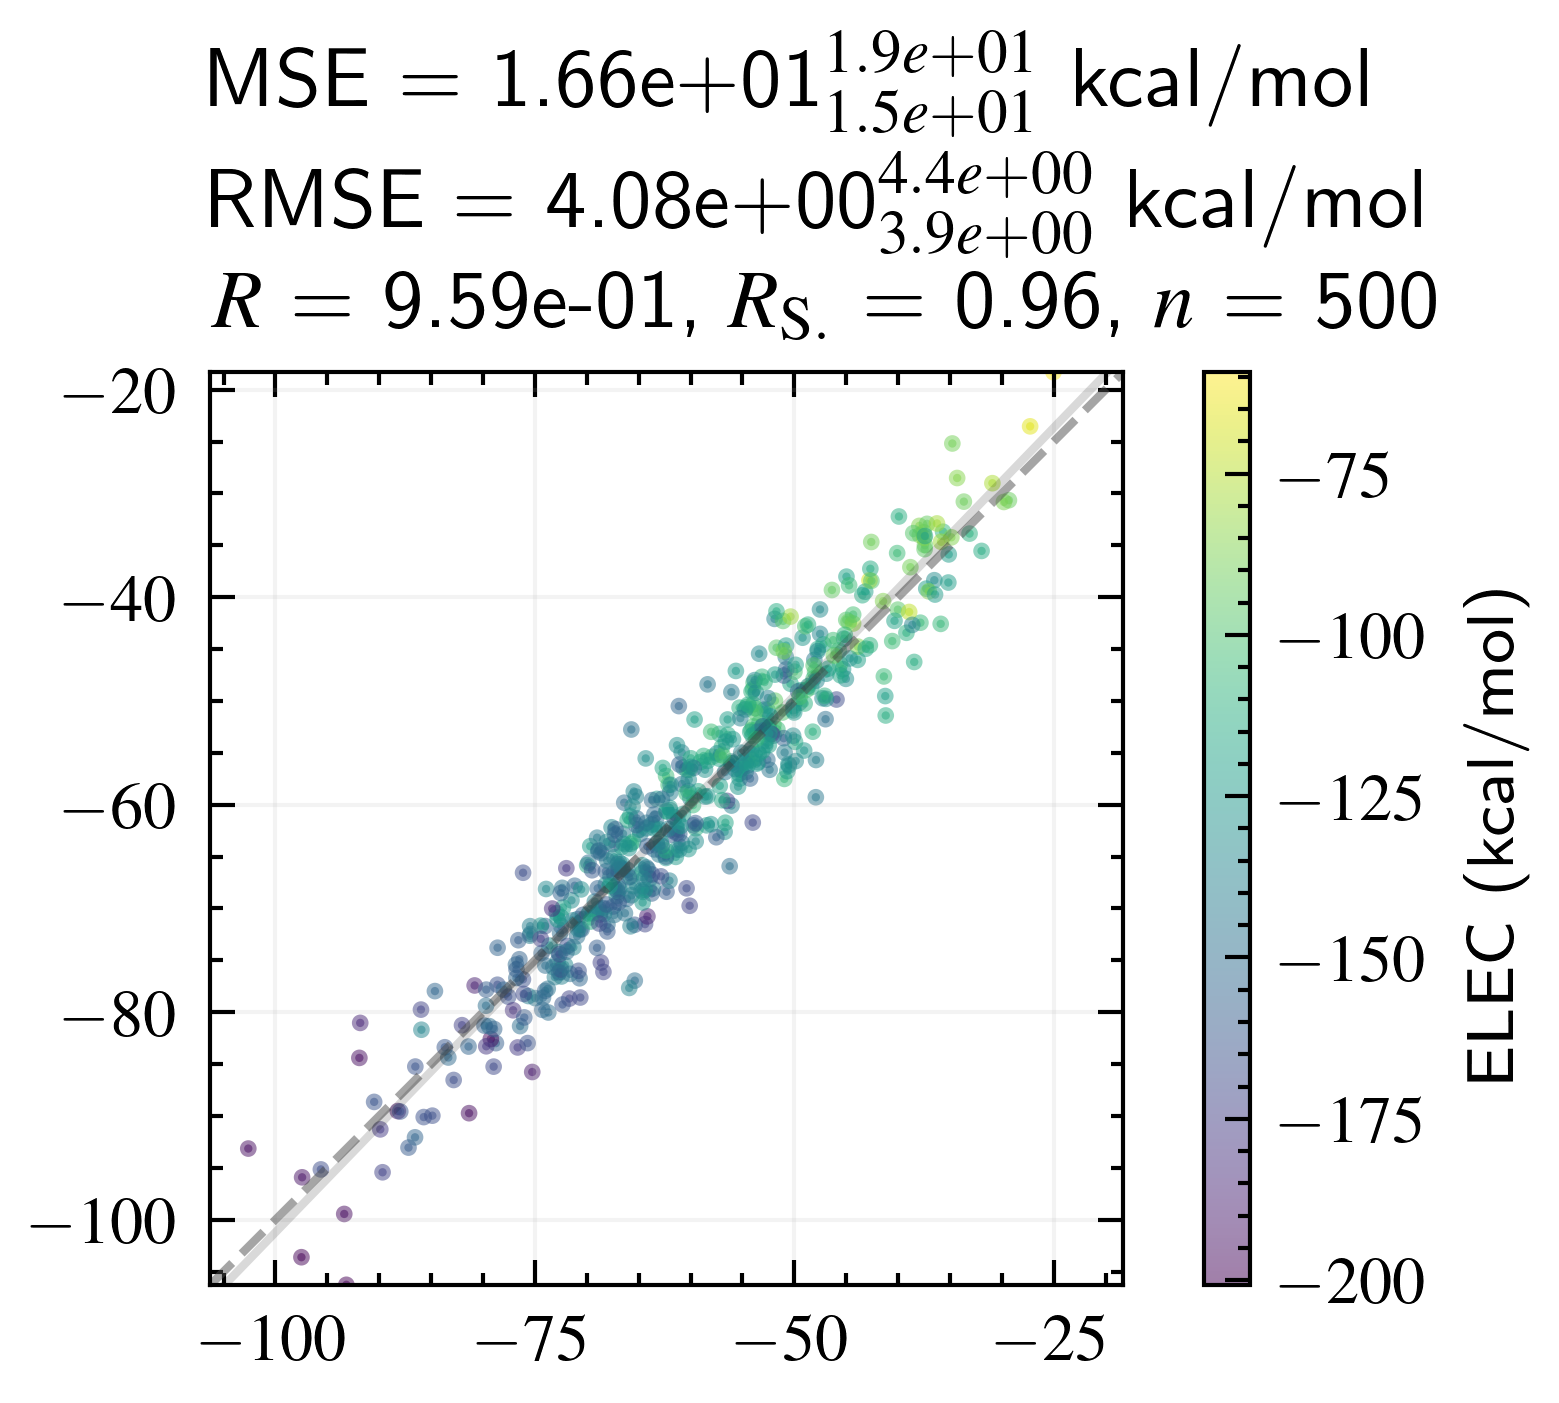

In [233]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data[LJFF.elec]

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ECOL")
plt.savefig("epol_exact_vs_intE.pdf")


#  LJ fit exact, ECOL fit


In [42]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_kmdcm_intE.pkl"))
LJFF

FF: LJ water_cluster ELEC harmonic ECOL (jax_coloumb: True)

In [43]:
# p = PKL_PATH / "water_cluster/pbe0dz/pbe0_dz.pc"
# data_ = Data(p)

In [44]:
# data_.data

In [45]:
# data_.monomer_df

In [46]:
# LJFF.data

In [47]:
LJFF.elec = "fit_ECOL"
LJFF.intE = "intE"
LJFF.intern = "Exact"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

71.63602


FF: LJ water_cluster fit_ECOL Exact intE (jax_coloumb: True)

In [48]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [49]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

fun  nit  nfev  status  success  \
1    121.090706  614  1064       0     True   
9    121.106247  647  1135       0     True   
5    121.138008  659  1146       0     True   
4    121.143555  656  1117       0     True   
0    134.366913  132   323       0     True   
10   134.482605  319   597       0     True   
2    159.031418  265   481       0     True   
6    181.817291  616  1057       0     True   
8    230.303329  537   946       0     True   
3   5448.357422   51   155       0     True   
7   5448.357422   41   143       0     True   

                                  message  \
1   Optimization terminated successfully.   
9   Optimization terminated successfully.   
5   Optimization terminated successfully.   
4   Optimization terminated successfully.   
0   Optimization terminated successfully.   
10  Optimization terminated successfully.   
2   Optimization terminated successfully.   
6   Optimization terminated successfully.   
8   Optimization terminated successfully.   
3   Optimization terminated successfully.   
7   Optimization terminated successfully.   

                                                    x  \
1   [0.18155859006192465, 2.4999892661589342, 0.00...   
9   [0.23739171148436772, 2.4999719086818692, 0.00...   
5   [0.0836732942126217, 2.4999948049562564, 0.002...   
4   [0.01771834609123972, 2.5, 0.001, 0.0039344109...   
0   [1496.1463249145506, 1437.977921449105, 1528.3...   
10  [0.001, 2.1347510445155766, 0.7065100065736939...   
2   [0.06007752904123744, 2.1666868090279365, 1.92...   
6   [1.0870969585001058, 2.5, 0.001, 0.00104723463...   
8   [1.4967419454461794, 2.0698446456635775, 0.001...   
3                            [0.001, 0.001, 2.5, 2.5]   
7   [0.001, 0.08251410109751023, 2.445367992817145...   

                                        final_simplex  
1   ([[0.18155859006192465, 2.4999892661589342, 0....  
9   ([[0.23739171148436772, 2.4999719086818692, 0....  
5   ([[0.0836732942126217, 2.4999948049562564, 0.0...  
4   ([[0.01771834609123972, 2.5, 0.001, 0.00393441...  
0   ([[1496.1463249145506, 1437.977921449105, 1528...  
10  ([[0.001, 2.1347510445155766, 0.70651000657369...  
2   ([[0.06007752904123744, 2.1666868090279365, 1....  
6   ([[1.0870969585001058, 2.5, 0.001, 0.001047234...  
8   ([[1.4967419454461794, 2.0698446456635775, 0.0...  
3   ([[0.001, 0.001, 2.5, 2.5], [0.001000836196274...  
7   ([[0.001, 0.08251410109751023, 2.4453679928171...

In [50]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([1.81558590e-01, 2.49998927e+00, 1.00000000e-03, 3.85473258e-03])

In [51]:
abs(LJFF.eval_jax(bestres)).mean()

Array(71.36874, dtype=float32)

In [52]:
abs(LJFF.targets).mean()

Array(71.63602, dtype=float32)

In [53]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

11.004122221766806

3.96311274509171e-221


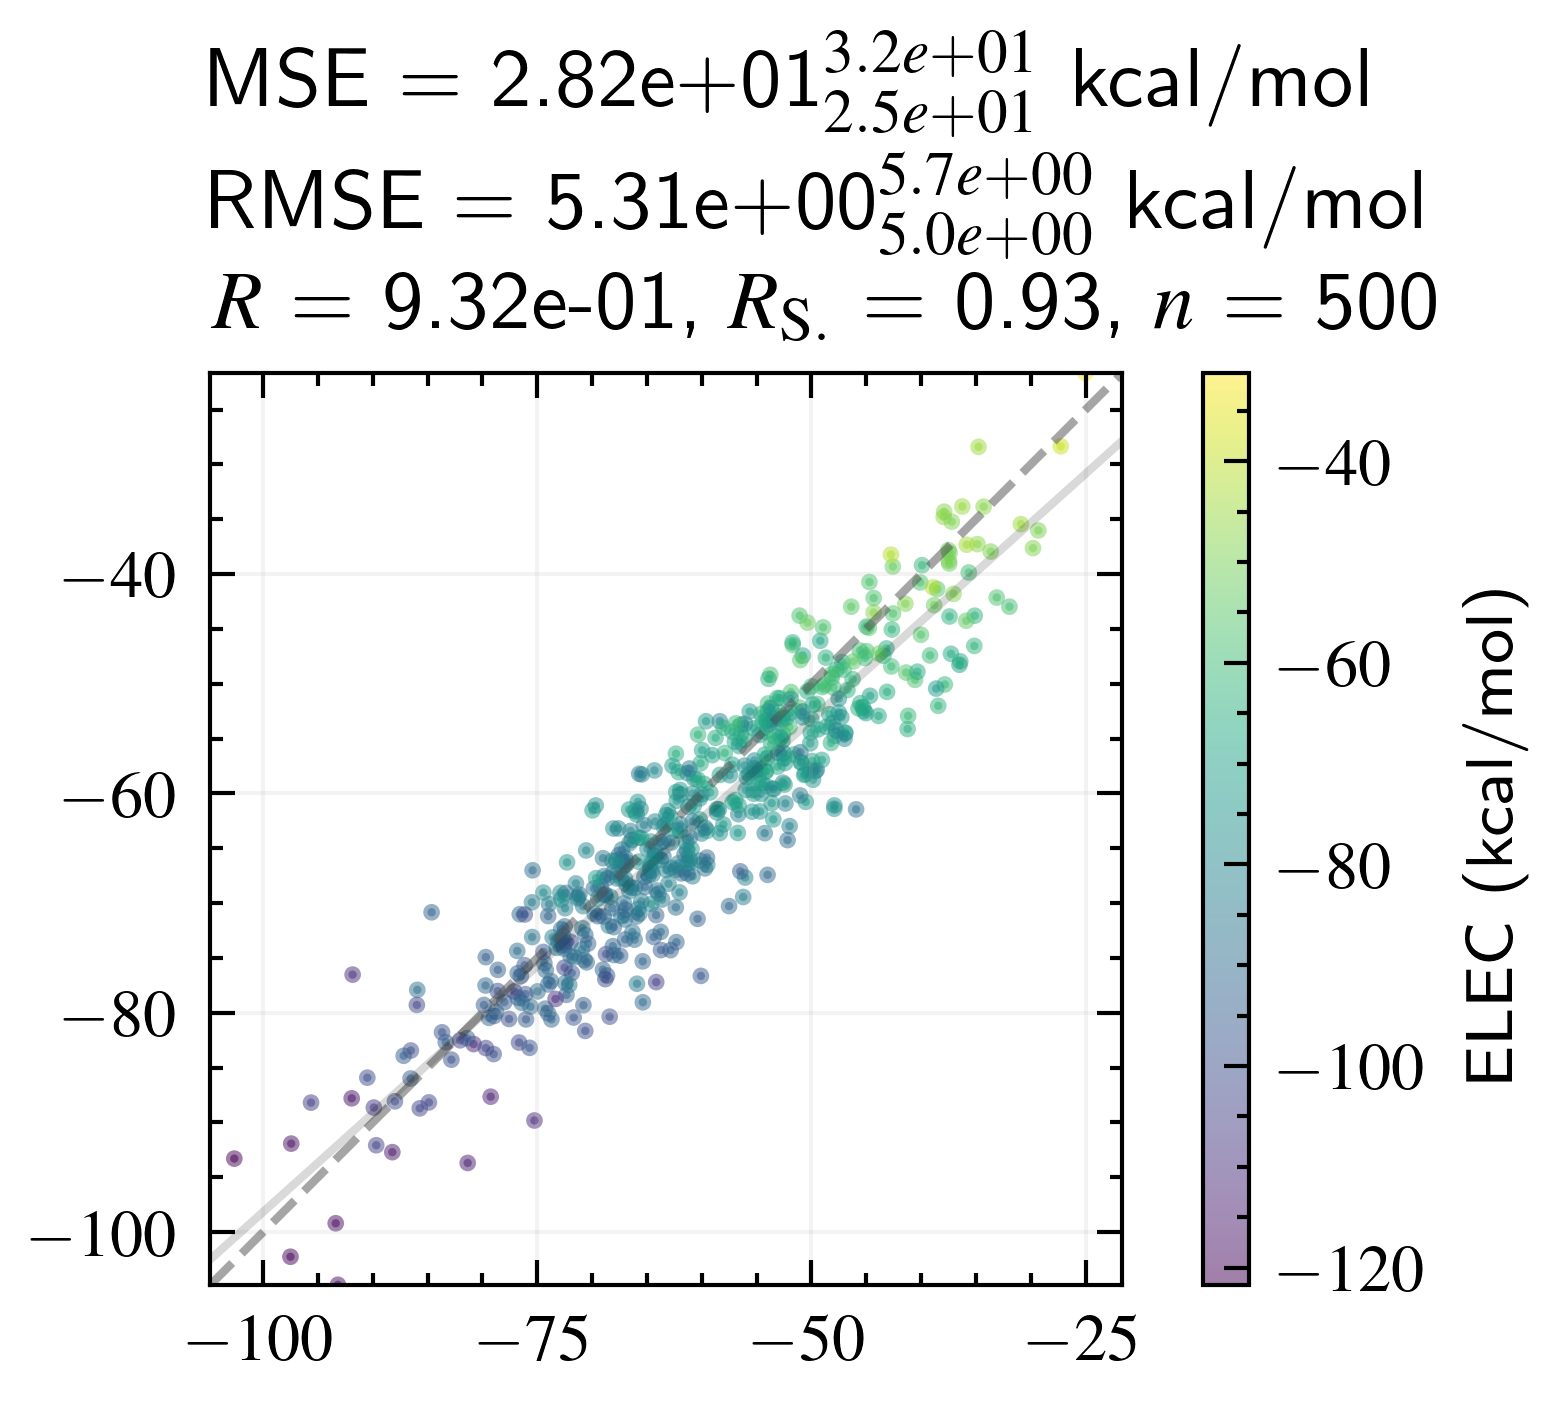

In [55]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data.ECOL

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ELEC")
plt.savefig("kmdcm_ecol_fit_exact_lj_fit.pdf")


#  LJ fit harmonic, ECOL fit


In [70]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_tip3_intE.pkl"))
LJFF

FF: LJ water_cluster ELEC harmonic ECOL (jax_coloumb: True)

In [58]:
# p = PKL_PATH / "water_cluster/pbe0dz/pbe0_dz.pc"
# data_ = Data(p)

In [59]:
# data_.data

In [60]:
# data_.monomer_df

In [61]:
# LJFF.data

In [72]:
LJFF.elec = "fit_ECOL"
LJFF.intE = "intE"
LJFF.intern = "harmonic"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

73.45566


FF: LJ water_cluster fit_ECOL harmonic intE (jax_coloumb: True)

In [73]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [74]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

fun  nit  nfev  status  success  \
1     71.694290  592  1036       0     True   
9     71.733078  422   765       0     True   
8     71.744820  410   704       0     True   
6     71.845879  560   943       0     True   
2     72.879051  553   990       0     True   
5     78.060135  425   761       0     True   
7     81.075462  485   859       0     True   
0     95.599182  120   298       0     True   
3    103.510803  313   593       0     True   
4   5667.767090   64   185       0     True   
10  5667.767090   42   148       0     True   

                                  message  \
1   Optimization terminated successfully.   
9   Optimization terminated successfully.   
8   Optimization terminated successfully.   
6   Optimization terminated successfully.   
2   Optimization terminated successfully.   
5   Optimization terminated successfully.   
7   Optimization terminated successfully.   
0   Optimization terminated successfully.   
3   Optimization terminated successfully.   
4   Optimization terminated successfully.   
10  Optimization terminated successfully.   

                                                    x  \
1   [0.2394108946356567, 2.5, 0.001, 0.00390726348...   
9   [0.02305640196626209, 2.499990072662656, 0.001...   
8   [0.001, 2.5, 0.0011272123076727896, 0.00403550...   
6   [0.001, 2.4999999611769237, 0.0080285416374640...   
2   [0.2739918192315576, 2.2829795092251435, 0.001...   
5   [0.001, 2.278187435824216, 0.2828617520411762,...   
7   [0.0015982896402723322, 2.2494366836046, 0.477...   
0   [1754.4221030693234, 1407.8747311091342, 1977....   
3   [0.001, 2.147273546367762, 2.5, 0.027443760767...   
4   [0.011581505543246141, 0.2413230936890809, 0.0...   
10  [0.043414902041985615, 0.001, 2.5, 0.776273900...   

                                        final_simplex  
1   ([[0.2394108946356567, 2.5, 0.001, 0.003907263...  
9   ([[0.02305640196626209, 2.499990072662656, 0.0...  
8   ([[0.001, 2.5, 0.0011272123076727896, 0.004035...  
6   ([[0.001, 2.4999999611769237, 0.00802854163746...  
2   ([[0.2739918192315576, 2.2829795092251435, 0.0...  
5   ([[0.001, 2.278187435824216, 0.282861752041176...  
7   ([[0.0015982896402723322, 2.2494366836046, 0.4...  
0   ([[1754.4221030693234, 1407.8747311091342, 197...  
3   ([[0.001, 2.147273546367762, 2.5, 0.0274437607...  
4   ([[0.011581505543246141, 0.2413230936890809, 0...  
10  ([[0.043414902041985615, 0.001, 2.5, 0.7762739...

In [75]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([2.39410895e-01, 2.50000000e+00, 1.00000000e-03, 3.90726349e-03])

In [76]:
abs(LJFF.eval_jax(bestres)).mean()

Array(73.14068, dtype=float32)

In [77]:
abs(LJFF.targets).mean()

Array(73.45566, dtype=float32)

In [78]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

8.467248086665041

6.418034547626314e-227


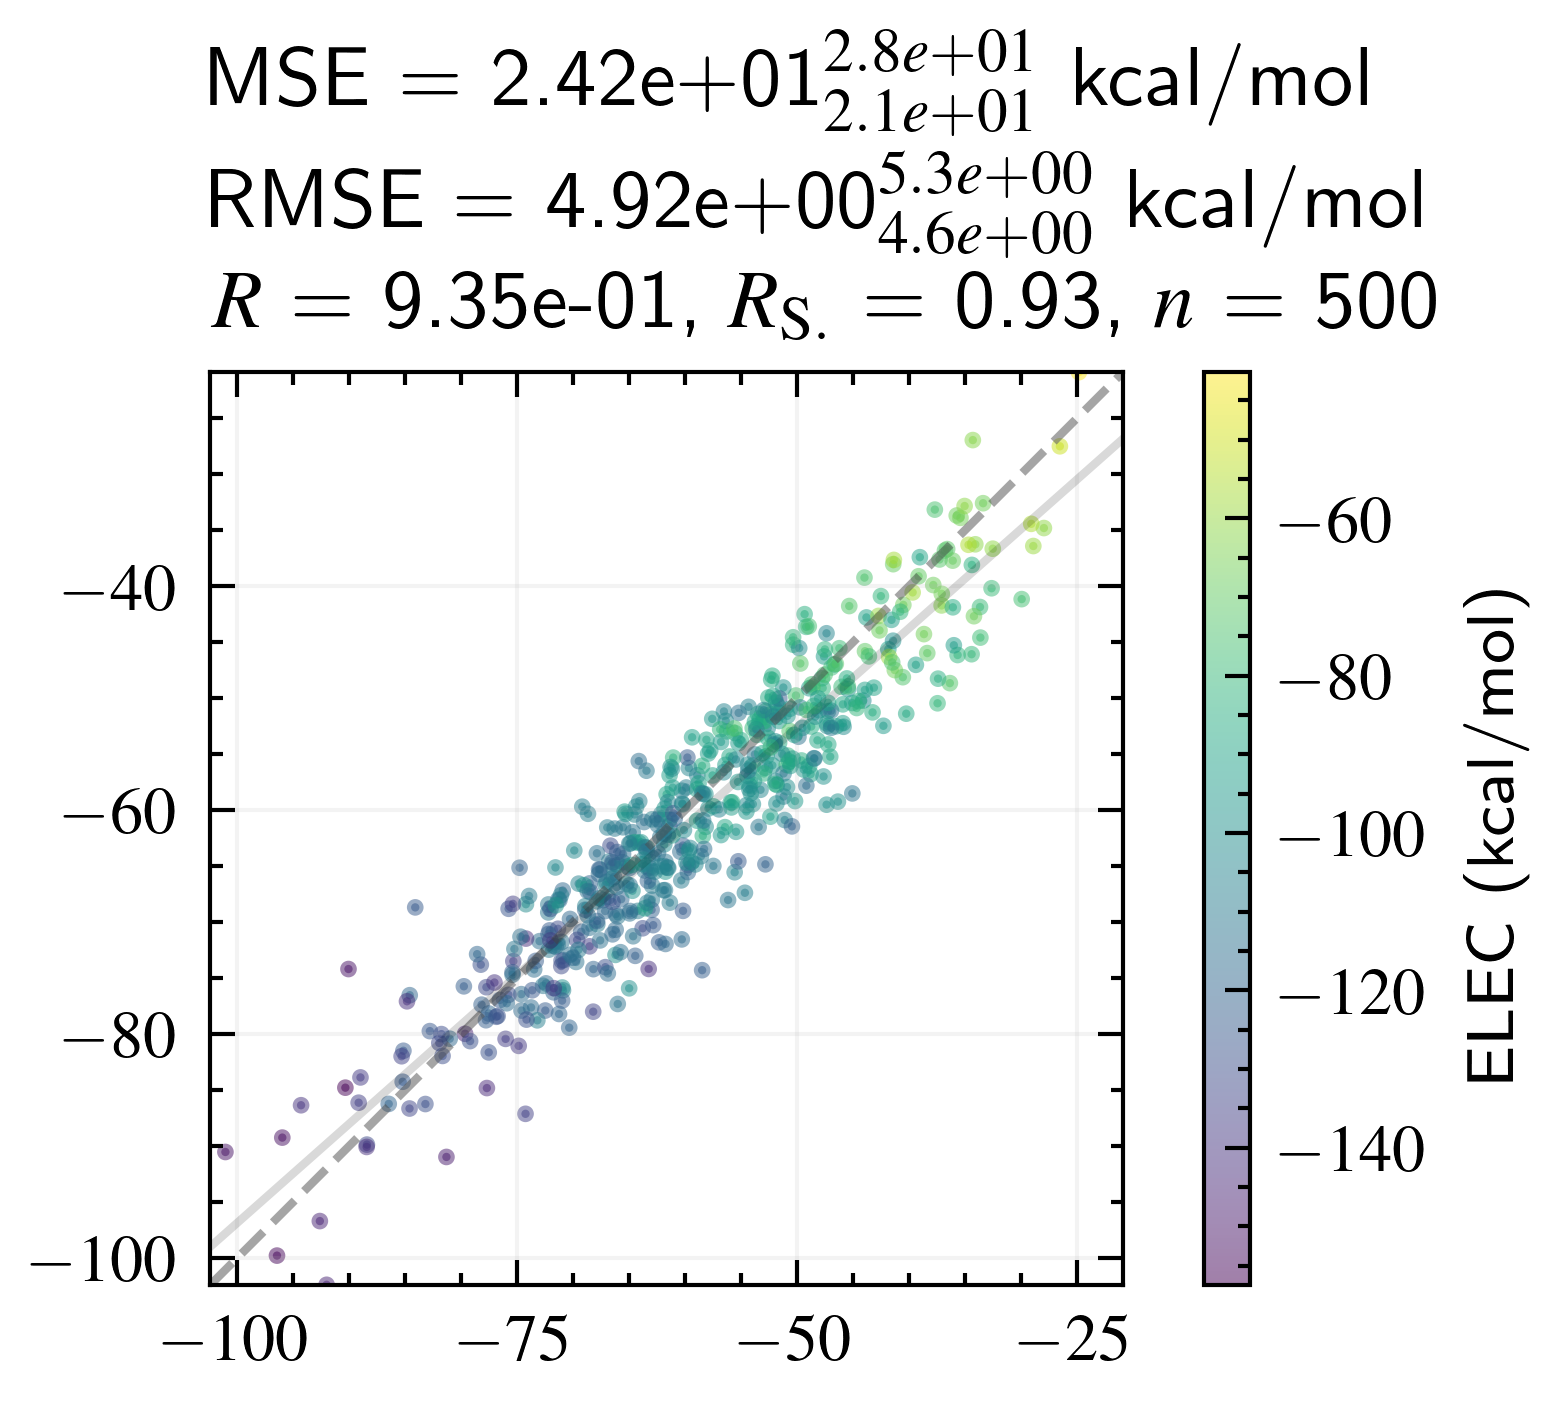

In [80]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data.ECOL

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ELEC")
plt.savefig("tip3_ecol_fit_harmonic_lj_fit.pdf")


#  DE fit


In [23]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
DEFF = next(read_from_pickle(f"ff/fit_ECOL_mdcm_intE.pkl"))
DEFF.elec = "fit_ECOL"
DEFF.data.intE.abs().mean()

59.12803914354881

In [24]:
fit_repeat(DEFF, 
           10, 
           "test",
           bounds = DE_bound,
           loss="jax_de",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [30]:
pd.DataFrame(DEFF.opt_results).sort_values("fun")

fun   nit  nfev  status  success  \
7    11.775151   964  1559       0     True   
11   11.775182   596  1013       0     True   
6    11.775245  1476  2327       0     True   
20   11.775511  1283  2046       0     True   
9    11.776557   581   946       0     True   
17   11.777202   943  1549       0     True   
1    11.792897  1024  1623       0     True   
16   11.793501   729  1197       0     True   
8    11.793520  1672  2621       0     True   
18   14.313481   740  1191       0     True   
12   14.325752   938  1491       0     True   
10   20.517012   772  1305       0     True   
4    23.921322   477   824       0     True   
5    27.359377   664  1120       0     True   
15   33.605865   629  1058       0     True   
13   33.612335   529   904       0     True   
2    34.125149   360   641       0     True   
14   35.429222  1288  2065       0     True   
3    38.942783   791  1311       0     True   
19   41.874851   554   968       0     True   
0   134.030228   119   318       0     True   

                                  message  \
7   Optimization terminated successfully.   
11  Optimization terminated successfully.   
6   Optimization terminated successfully.   
20  Optimization terminated successfully.   
9   Optimization terminated successfully.   
17  Optimization terminated successfully.   
1   Optimization terminated successfully.   
16  Optimization terminated successfully.   
8   Optimization terminated successfully.   
18  Optimization terminated successfully.   
12  Optimization terminated successfully.   
10  Optimization terminated successfully.   
4   Optimization terminated successfully.   
5   Optimization terminated successfully.   
15  Optimization terminated successfully.   
13  Optimization terminated successfully.   
2   Optimization terminated successfully.   
14  Optimization terminated successfully.   
3   Optimization terminated successfully.   
19  Optimization terminated successfully.   
0   Optimization terminated successfully.   

                                                    x  \
7   [0.3411363344649736, 1.2834539826299567, 2.5, ...   
11  [0.3410279489227199, 1.2835442577247882, 2.499...   
6   [0.34114571204260147, 1.283410496813493, 2.499...   
20  [0.3406634610028251, 1.2834286543030644, 2.499...   
9   [0.3407296851411241, 1.2837287936298885, 2.499...   
17  [0.34070603589209786, 1.2838674274856148, 2.49...   
1   [0.3391777333651863, 1.2858844652607933, 2.499...   
16  [0.3392183785149385, 1.2858566511837575, 2.499...   
8   [0.33895459035051223, 1.2859510668931469, 2.49...   
18  [0.4379737380241687, 1.1385457267294805, 2.5, ...   
12  [0.43833771446185005, 1.1379701309005332, 2.49...   
10  [0.46796066298583905, 1.2044427432360578, 1.53...   
4   [0.001, 1.2907157262089526, 2.499923577660084,...   
5   [0.6161173084663786, 0.9188120473875862, 2.498...   
15  [0.9731513327556881, 0.6538647941567033, 1.450...   
13  [0.38562017033823703, 1.2997886058740498, 0.00...   
2   [0.001, 1.2998259685811009, 0.001, 2.5, 4.0857...   
14  [0.9671725643392481, 0.001, 1.27681100303188, ...   
3   [0.001, 1.0968050479132538, 0.0523251363165256...   
19  [0.4802100772037339, 0.4689571664118677, 1.917...   
0   [288.88061219207106, 445.76891948291154, 627.4...   

                                        final_simplex  
7   ([[0.3411363344649736, 1.2834539826299567, 2.5...  
11  ([[0.3410279489227199, 1.2835442577247882, 2.4...  
6   ([[0.34114571204260147, 1.283410496813493, 2.4...  
20  ([[0.3406634610028251, 1.2834286543030644, 2.4...  
9   ([[0.3407296851411241, 1.2837287936298885, 2.4...  
17  ([[0.34070603589209786, 1.2838674274856148, 2....  
1   ([[0.3391777333651863, 1.2858844652607933, 2.4...  
16  ([[0.3392183785149385, 1.2858566511837575, 2.4...  
8   ([[0.33895459035051223, 1.2859510668931469, 2....  
18  ([[0.4379737380241687, 1.1385457267294805, 2.5...  
12  ([[0.43833771446185005, 1.1379701309005332, 2....  
10  ([[0.46796066298583905, 1.2044427432360578, 1....  
4 

In [27]:
# np.sqrt(10.7)

In [28]:
best = list(pd.DataFrame(\
                  DEFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

3.4314940263311815

/home/boittier/miniconda3/envs/pycharmm/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


2.0136656937969305e-19


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 1.2343012918828257e+76,
  'RMSE': 1.110991130424913e+38,
  'R': -0.38811610661346574,
  'RS': -0.3537352069408277,
  'n': 500,
  'slope': -9.093174018307893e+35,
  'intercept': inf})

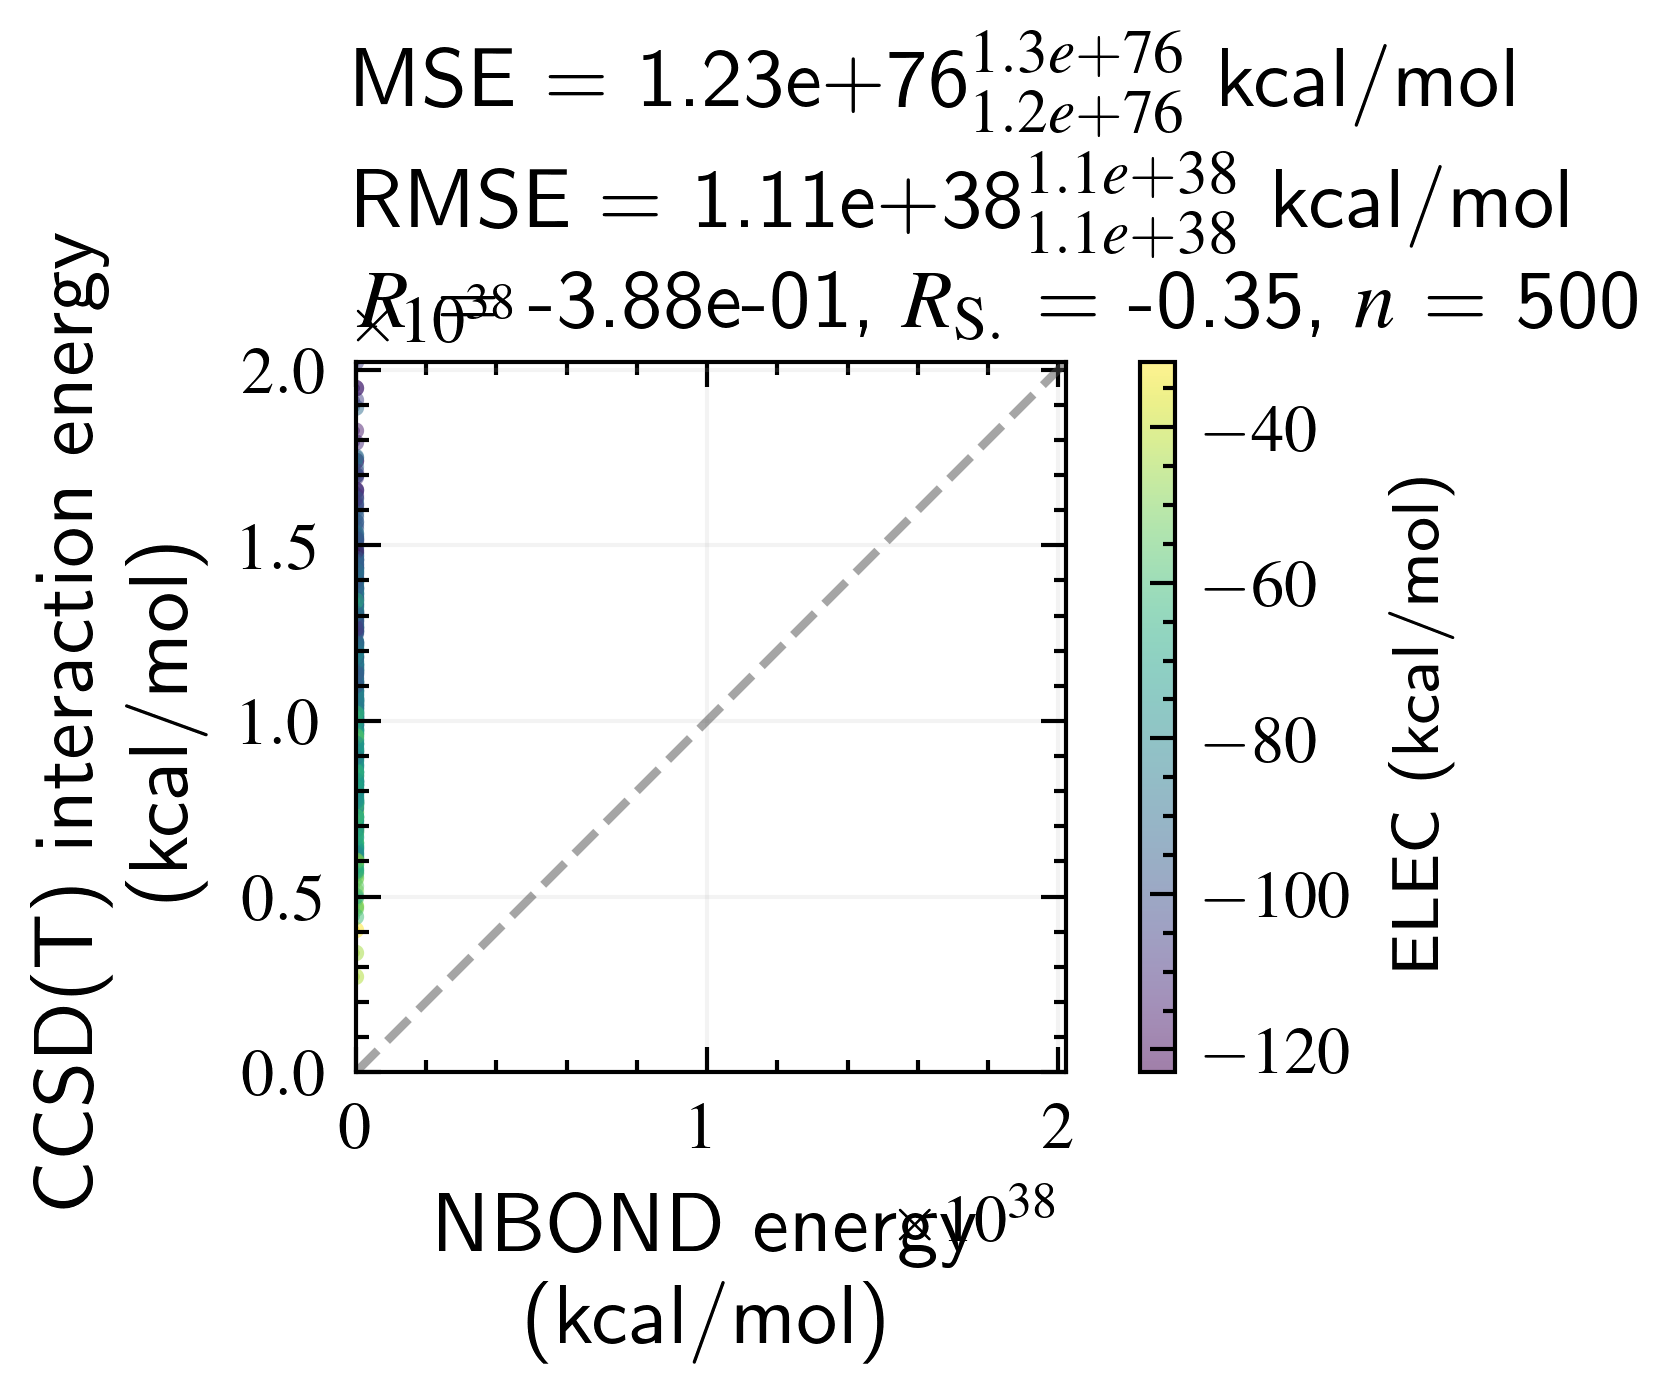

In [63]:
LJFF.data["fit_intE"] = LJFF.eval_jax(resx) + LJFF.data.ELEC

plot_energy_MSE(DEFF.data, "intE", "fit_intE",  elec = "ELEC")



In [27]:
resx = list(pd.DataFrame(\
                  DEFF.opt_results)\
     .sort_values("fun").x)[0]

(array([  7.,  27.,  43.,  79., 100., 111.,  64.,  50.,  13.,   6.]),
 array([-77.66558075, -72.58831787, -67.51104736, -62.43378067,
        -57.35651779, -52.2792511 , -47.20198441, -42.12471771,
        -37.04745102, -31.97018623, -26.89291954]),
 <BarContainer object of 10 artists>)

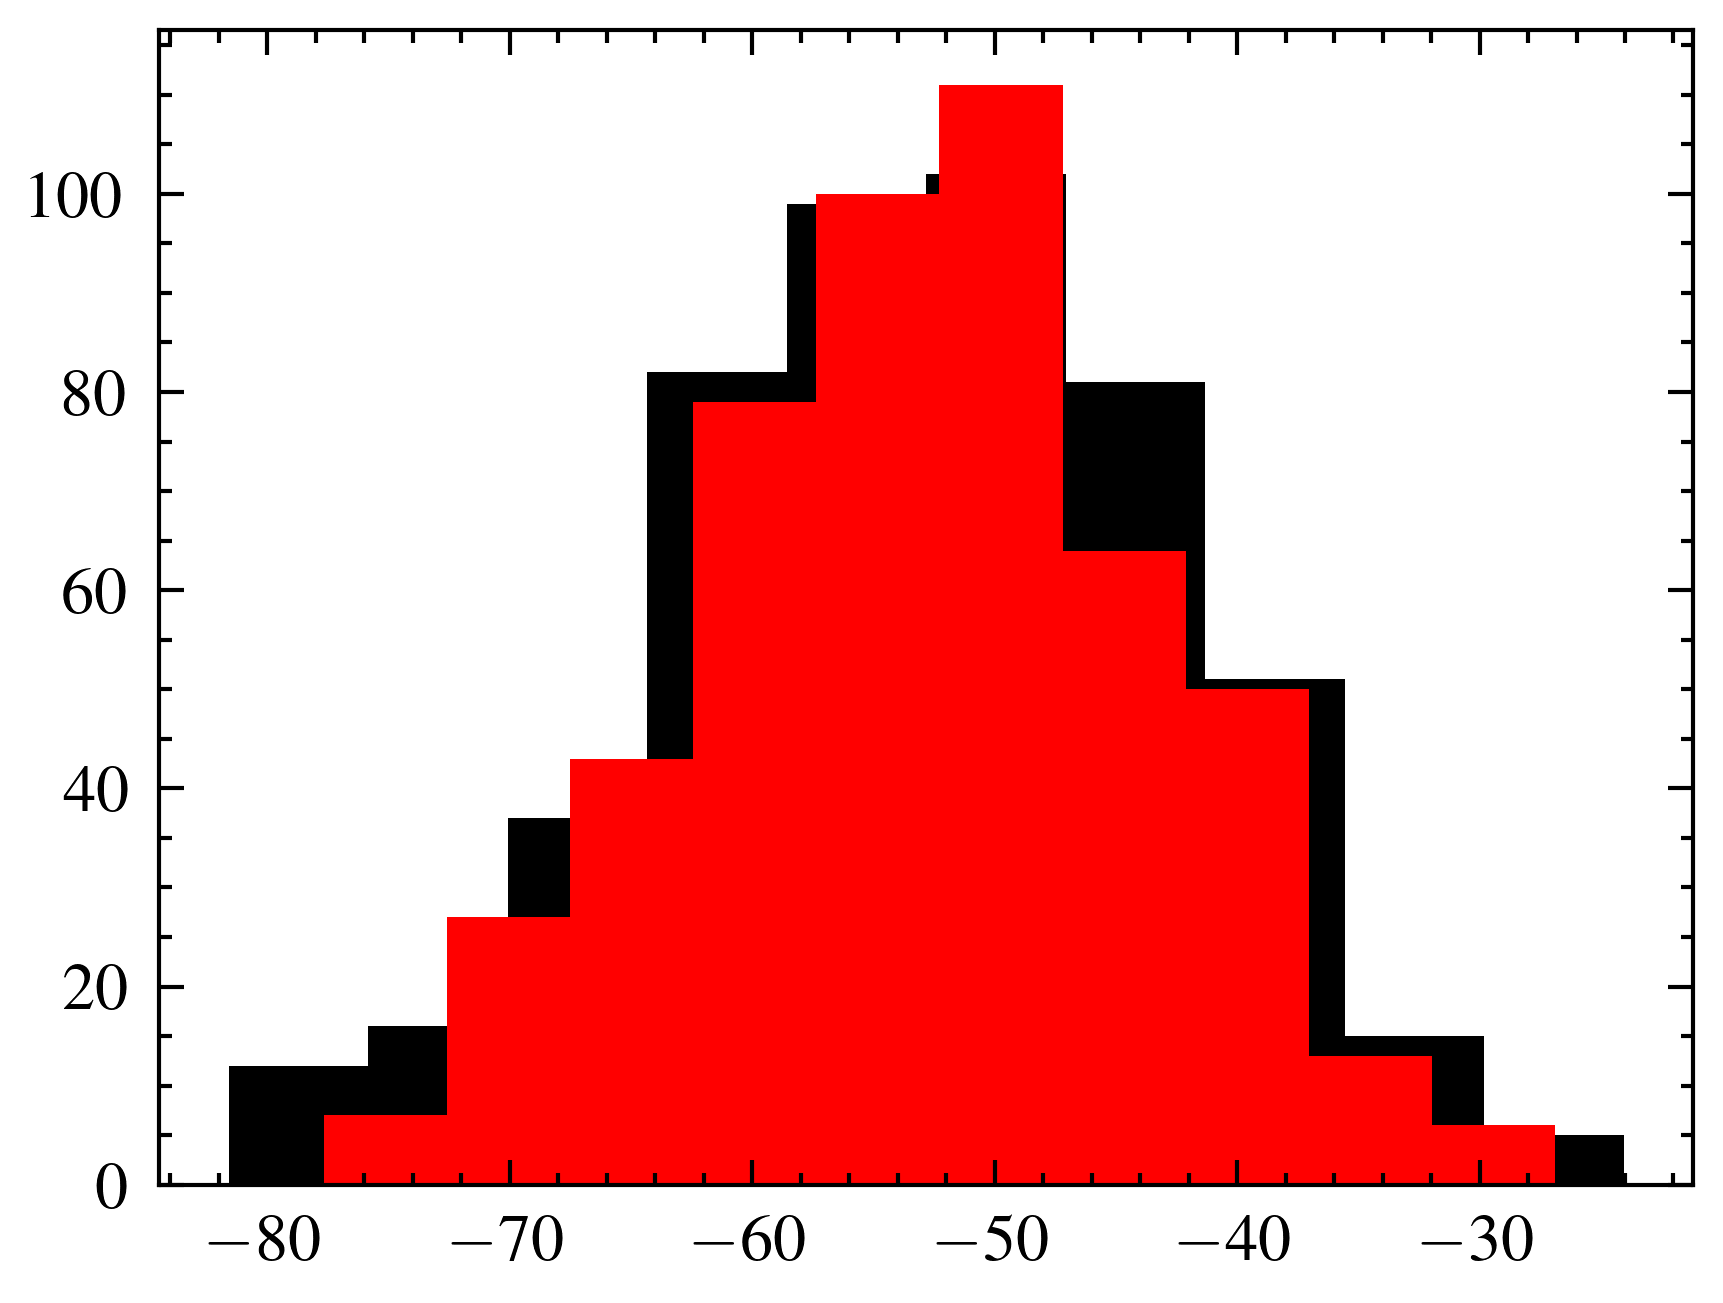

In [32]:
plt.hist(DEFF.targets)
plt.hist(DEFF.eval_jax_de(resx))

In [30]:
resx

array([ 0.34116161,  1.28335808,  2.5       ,  2.49999817,  7.37977031,
       19.28580408])

0.0


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 11.775170940231728,
  'RMSE': 3.431496894976262,
  'R': 0.9907021031578068,
  'RS': 0.9895893343573374,
  'n': 500,
  'slope': 0.9575077841699374,
  'intercept': -5.660148647068695})

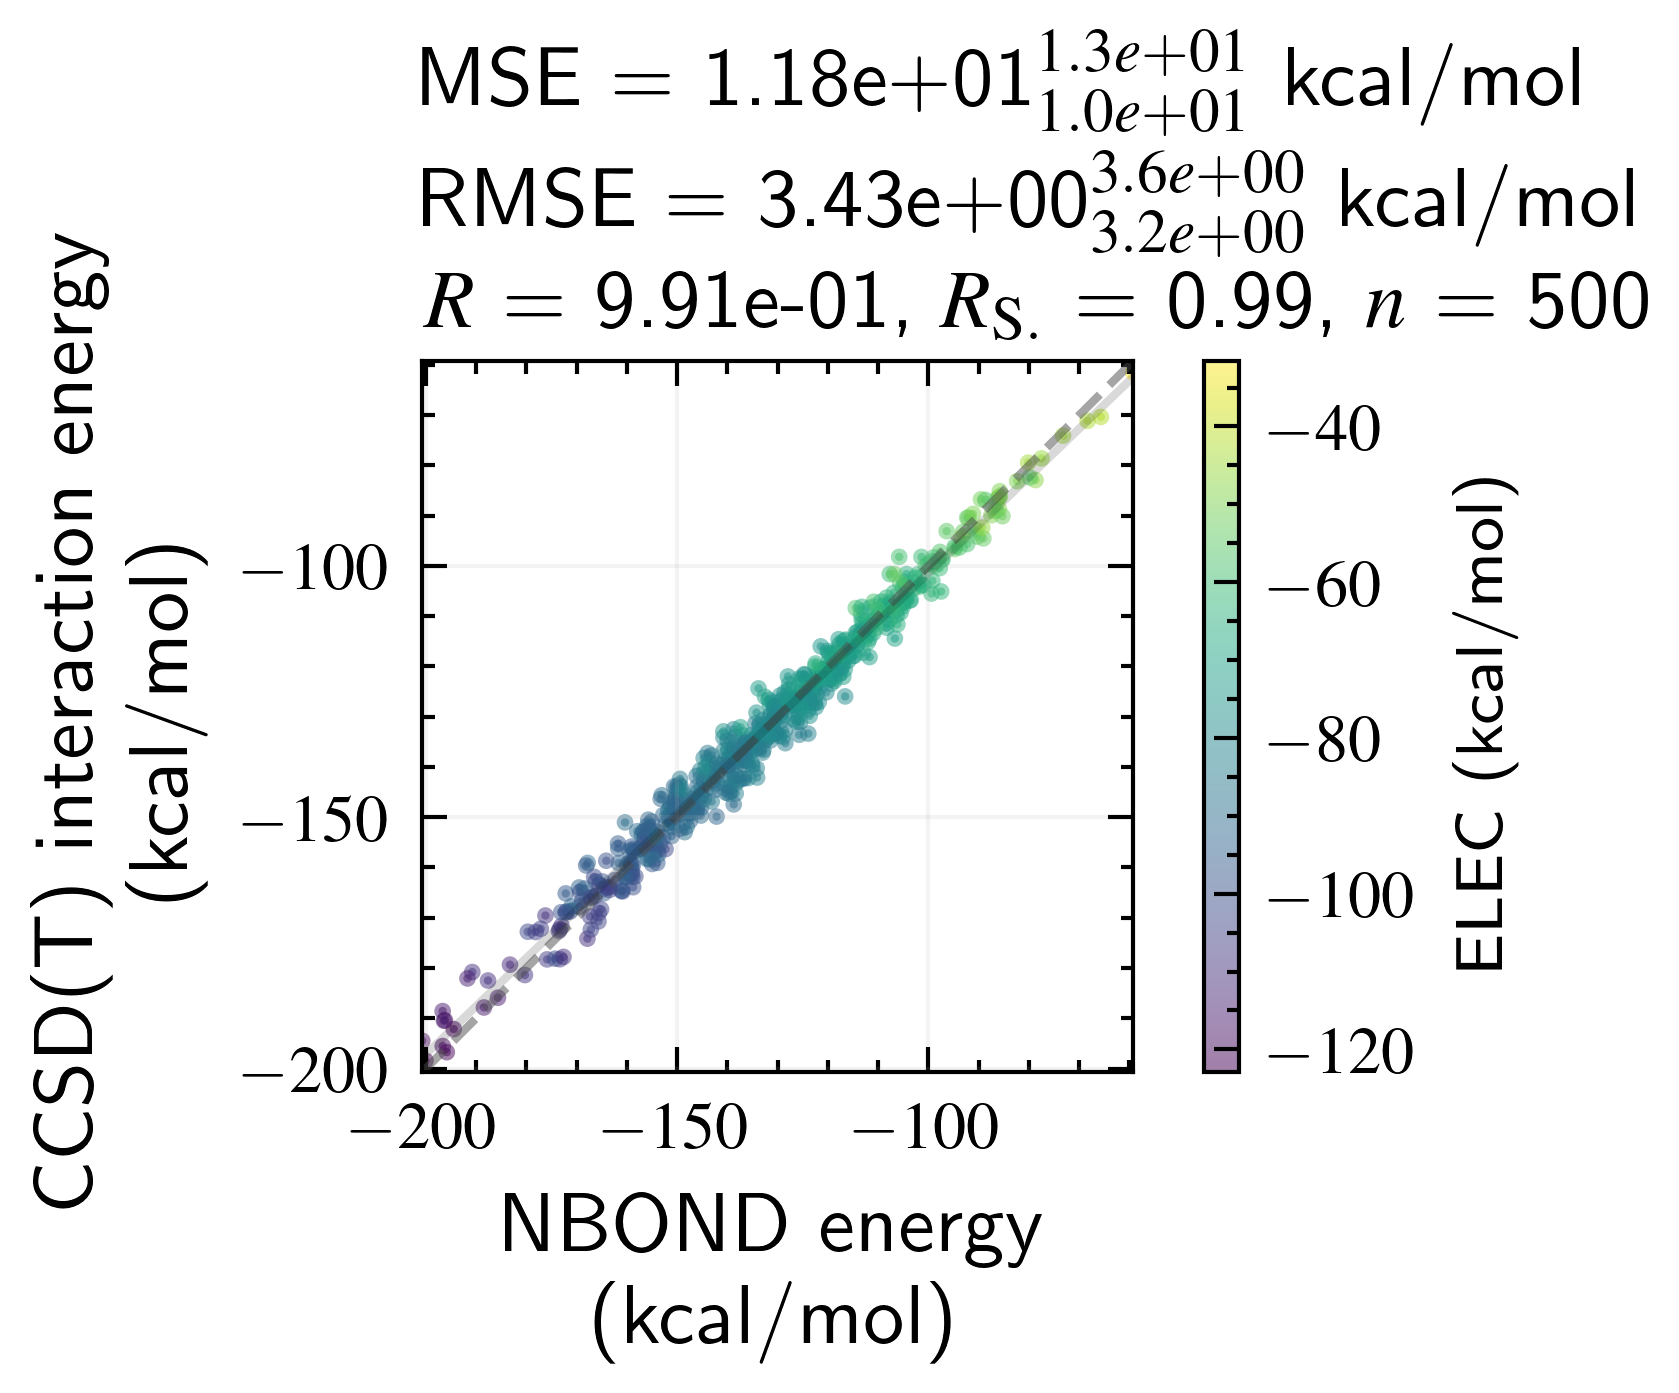

In [31]:
DEFF.data["fit_ECOL_"] = DEFF.eval_jax_de(resx) + _c.data.ELEC

plot_energy_MSE(DEFF.data, "ECOL", "fit_ECOL_",  elec = "ELEC")

